In [1]:
! pip install -r requirements.txt

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel,RFECV
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
import xgboost as xgb
import pickle
from itertools import combinations

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer,precision_score,recall_score,f1_score,classification_report,roc_curve,auc,precision_recall_curve,average_precision_score
from IPython.display import display, HTML

# Wyświetlanie notebooka
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

random_state=42

In [3]:
car_kick = pd.read_csv("data/car_kick.csv")

In [4]:
car_kick.head()

,PurchDate,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,...,WheelTypeID,WheelType,Nationality,Size,TopThreeAmericanName,BYRNO,VNZIP1,VNST,IsOnlineSale,Class
0,1.289952e+09,2006.0,4,51954.0,6197.0,7062.0,9605.0,10426.0,5341.0,6351.0,...,2.0,Covers,AMERICAN,MEDIUM,CHRYSLER,99750,32124,FL,0,0
1,1.242691e+09,2005.0,4,89127.0,3688.0,4783.0,4483.0,5666.0,3688.0,4783.0,...,2.0,Covers,AMERICAN,MEDIUM,FORD,20833,78754,TX,0,0
2,1.248221e+09,2006.0,3,71271.0,6897.0,8449.0,7949.0,9625.0,6868.0,8549.0,...,1.0,Alloy,AMERICAN,LARGE,GM,22916,80011,CO,0,0
3,1.285718e+09,2008.0,2,83338.0,7878.0,8925.0,11723.0,13026.0,7801.0,8704.0,...,2.0,Covers,AMERICAN,LARGE,GM,23657,94544,CA,0,0
4,1.237334e+09,2007.0,2,58698.0,8800.0,10091.0,10004.0,11398.0,7355.0,8543.0,...,1.0,Alloy,AMERICAN,LARGE,GM,20833,77086,TX,0,0


In [5]:
target = 'Class'
num_features = []
cat_features = []

In [6]:
car_kick.columns

Index(['PurchDate', 'VehYear', 'VehicleAge', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'VehBCost', 'WarrantyCost', 'Auction', 'Make', 'Model', 'Trim',
       'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1',
       'VNST', 'IsOnlineSale', 'Class'],
      dtype='object')

# Class - Class of the car (target variable)

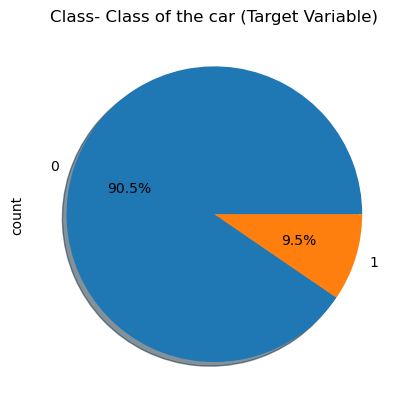

In [7]:
car_kick['Class'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, title="Class- Class of the car (Target Variable)");

In [8]:
#The dataset is imbalanced

In [9]:
car_kick.isnull().sum()

PurchDate                            0
VehYear                              0
VehicleAge                           0
VehOdo                               0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
VehBCost                             0
WarrantyCost                         0
Auction                              0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelTypeID                          0
WheelType                            0
Nationality                          0
Size                                 0
TopThreeAmericanName     

In [10]:
#### There is no missing data

# PurchDate - Purchase Date

In [11]:
car_kick['PurchDate'] =  pd.to_datetime(car_kick['PurchDate']) 

In [12]:
def from_dob_to_age(purchase_date):
    today = datetime.date.today()
    if (purchase_date.year > today.year):
        return today.year - (purchase_date.year-100) - ((today.month, today.day) < (purchase_date.month, purchase_date.day))
    return today.year - purchase_date.year - ((today.month, today.day) < (purchase_date.month, purchase_date.day))

In [13]:
car_kick['PurchAge'] = car_kick['PurchDate'].apply(lambda x: from_dob_to_age(x))

In [14]:
car_kick.head()

,PurchDate,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,...,WheelType,Nationality,Size,TopThreeAmericanName,BYRNO,VNZIP1,VNST,IsOnlineSale,Class,PurchAge
0,1970-01-01 00:00:01.289952000,2006.0,4,51954.0,6197.0,7062.0,9605.0,10426.0,5341.0,6351.0,...,Covers,AMERICAN,MEDIUM,CHRYSLER,99750,32124,FL,0,0,53
1,1970-01-01 00:00:01.242691200,2005.0,4,89127.0,3688.0,4783.0,4483.0,5666.0,3688.0,4783.0,...,Covers,AMERICAN,MEDIUM,FORD,20833,78754,TX,0,0,53
2,1970-01-01 00:00:01.248220800,2006.0,3,71271.0,6897.0,8449.0,7949.0,9625.0,6868.0,8549.0,...,Alloy,AMERICAN,LARGE,GM,22916,80011,CO,0,0,53
3,1970-01-01 00:00:01.285718400,2008.0,2,83338.0,7878.0,8925.0,11723.0,13026.0,7801.0,8704.0,...,Covers,AMERICAN,LARGE,GM,23657,94544,CA,0,0,53
4,1970-01-01 00:00:01.237334400,2007.0,2,58698.0,8800.0,10091.0,10004.0,11398.0,7355.0,8543.0,...,Alloy,AMERICAN,LARGE,GM,20833,77086,TX,0,0,53


In [15]:
#I'll drop the values beacuse they are irrelevant now
car_kick = car_kick.drop(['PurchDate'], axis=1)

In [16]:
car_kick['PurchAge'].unique()

array([53])

In [17]:
#We can drop the value, because all data if from the same year
#I'll drop the values beacuse they are irrelevant now
car_kick = car_kick.drop(['PurchAge'], axis=1)

# VehYear - Year the car was produced

In [18]:
print(type(car_kick.VehYear[0]))
print(car_kick.VehYear[0])

<class 'numpy.float64'>
2006.0


In [19]:
def distplot_mean_median(column, title = ""):
    
    mean=column.mean()
    median=column.median()
    #mode=column.mode().get_values()[0]
    fig = plt.figure(figsize=(5,1))
    ax = fig.add_subplot(111)
    sns.boxplot(column)
    plt.axvline(mean, color='r', linestyle='--')
    plt.axvline(median, color='b', linestyle='-')
    #ax_box.axvline(mode, color='b', linestyle='-')
    
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    #ax.set_facecolor((0,0,0.10))
    s = sns.distplot(column)
    plt.axvline(mean, color='red', linewidth=1.5, label="mean")
    plt.axvline(median, color='blue', linewidth=1.5, label="median")
    plt.legend(loc='upper right', prop={'size': 20})
    plt.title(title)
    plt.show()

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


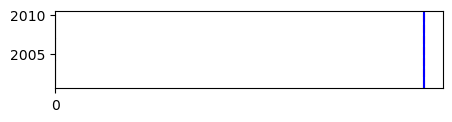

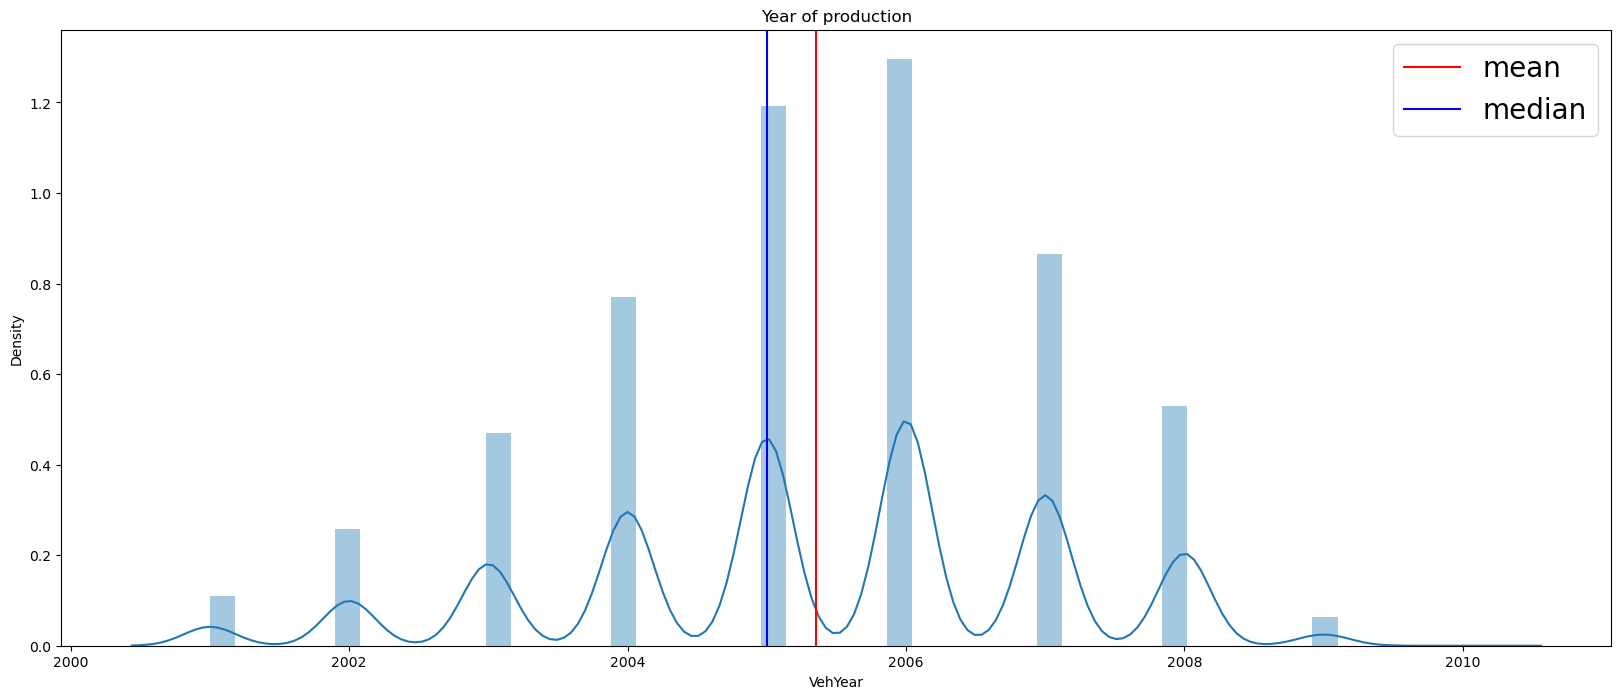

In [20]:
car_kick['VehYear'] = car_kick['VehYear'].astype(int)
distplot_mean_median(column=car_kick['VehYear'], title="Year of production")

In [21]:
#I will change the date to age of the car
car_kick['VehAge'] = car_kick['VehYear'].apply(lambda x: int(datetime.date.today().year) - x)

In [22]:
#And I will drop no longer needed cathegory
car_kick = car_kick.drop(['VehYear'], axis=1)

In [23]:
num_features.append('VehAge')

# VehicleAge - Age of the car

In [24]:
car_kick.head()

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,WheelType,Nationality,Size,TopThreeAmericanName,BYRNO,VNZIP1,VNST,IsOnlineSale,Class,VehAge
0,4,51954.0,6197.0,7062.0,9605.0,10426.0,5341.0,6351.0,8513.0,9822.0,...,Covers,AMERICAN,MEDIUM,CHRYSLER,99750,32124,FL,0,0,17
1,4,89127.0,3688.0,4783.0,4483.0,5666.0,3688.0,4783.0,4483.0,5666.0,...,Covers,AMERICAN,MEDIUM,FORD,20833,78754,TX,0,0,18
2,3,71271.0,6897.0,8449.0,7949.0,9625.0,6868.0,8549.0,7917.0,9733.0,...,Alloy,AMERICAN,LARGE,GM,22916,80011,CO,0,0,17
3,2,83338.0,7878.0,8925.0,11723.0,13026.0,7801.0,8704.0,11995.0,12901.0,...,Covers,AMERICAN,LARGE,GM,23657,94544,CA,0,0,15
4,2,58698.0,8800.0,10091.0,10004.0,11398.0,7355.0,8543.0,8443.0,9726.0,...,Alloy,AMERICAN,LARGE,GM,20833,77086,TX,0,0,16


In [25]:
#check is Vehicle age equal to new category VehAge
car_kick[['VehAge', 'VehicleAge']]

,VehAge,VehicleAge
0,17,4
1,18,4
2,17,3
3,15,2
4,16,2
...,...,...
67206,15,2
67207,19,6
67208,19,6
67209,20,7


#### these dates don't match, it's good to keep that in mind

In [26]:
num_features.append('VehicleAge')

# VehOdo - How far the car has driven in km

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


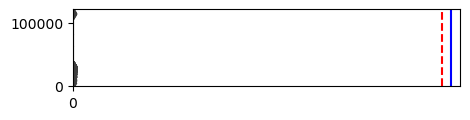

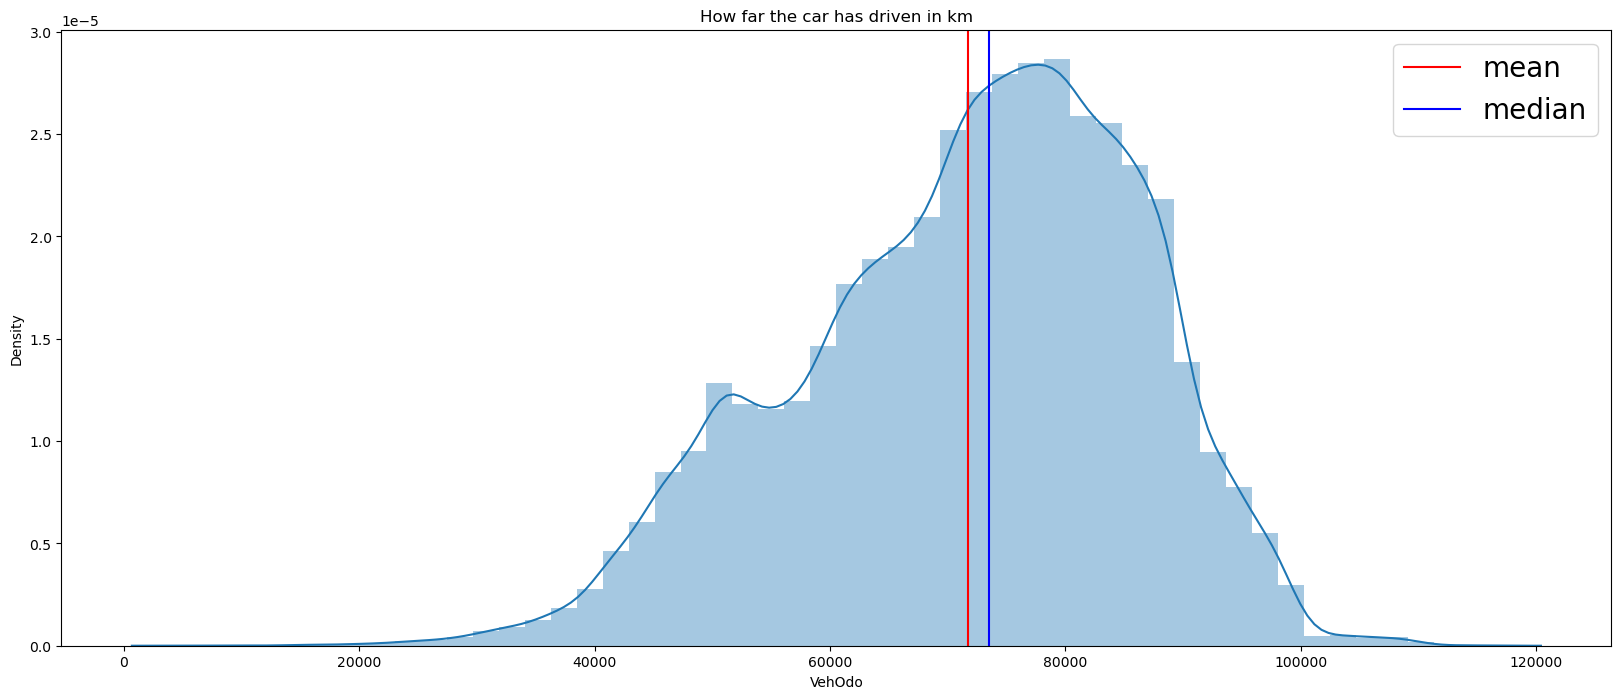

In [27]:
car_kick['VehOdo'] = car_kick['VehOdo'].astype(int)
distplot_mean_median(column=car_kick['VehOdo'], title="How far the car has driven in km")

In [28]:
num_features.append('VehOdo')

# MMRAcquisitionAuctionAveragePrice - Price of the car when is was bought at auction, average

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


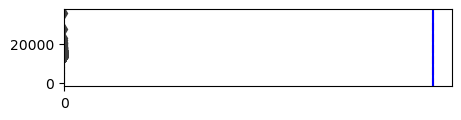

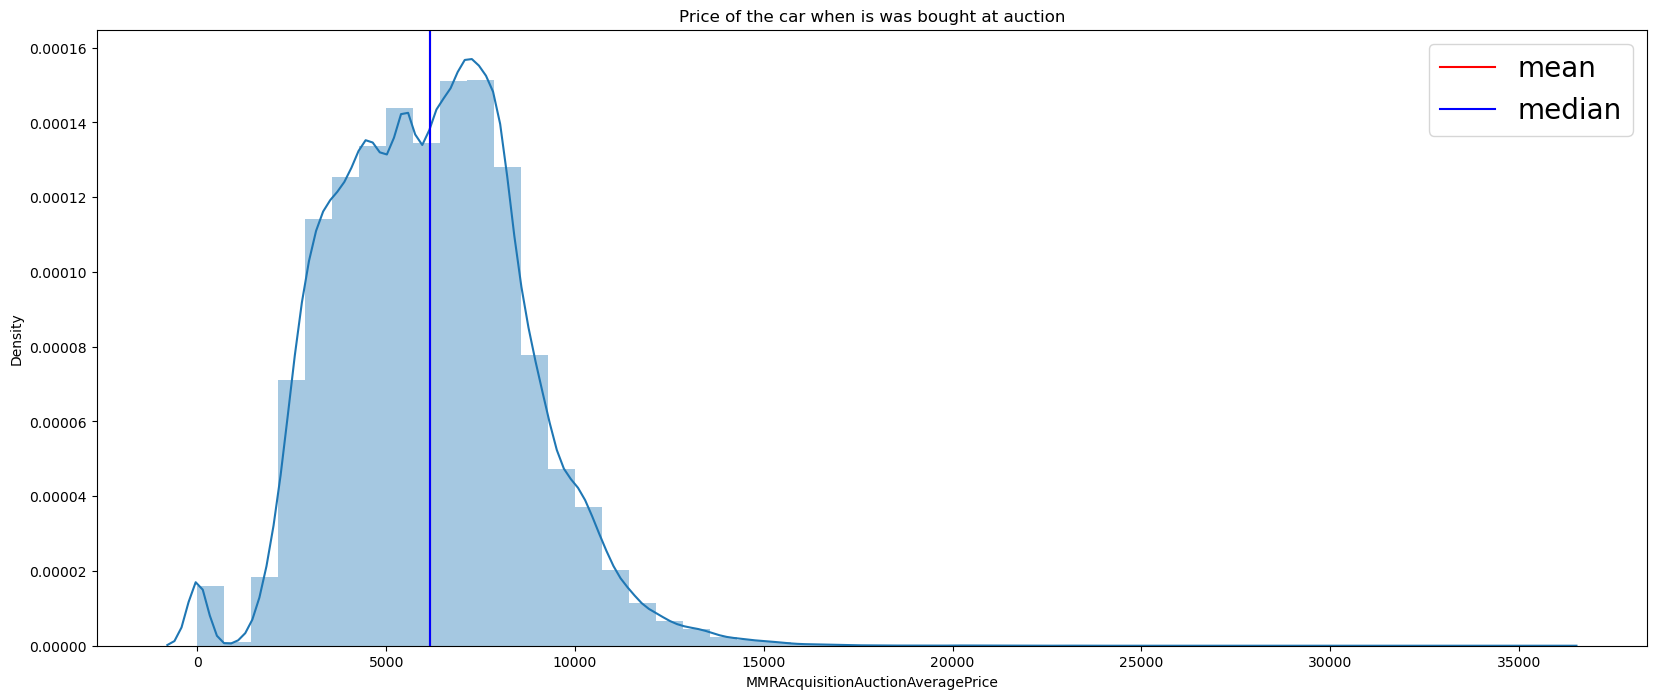

In [29]:
distplot_mean_median(column=car_kick['MMRAcquisitionAuctionAveragePrice'], title="Price of the car when is was bought at auction")

In [30]:
num_features.append('MMRAcquisitionAuctionAveragePrice')

# MMRAcquisitionAuctionCleanPrice - Price of the car when it was bought at auction, before fees

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


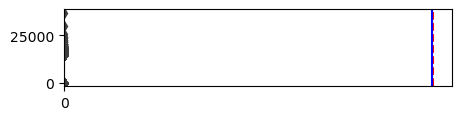

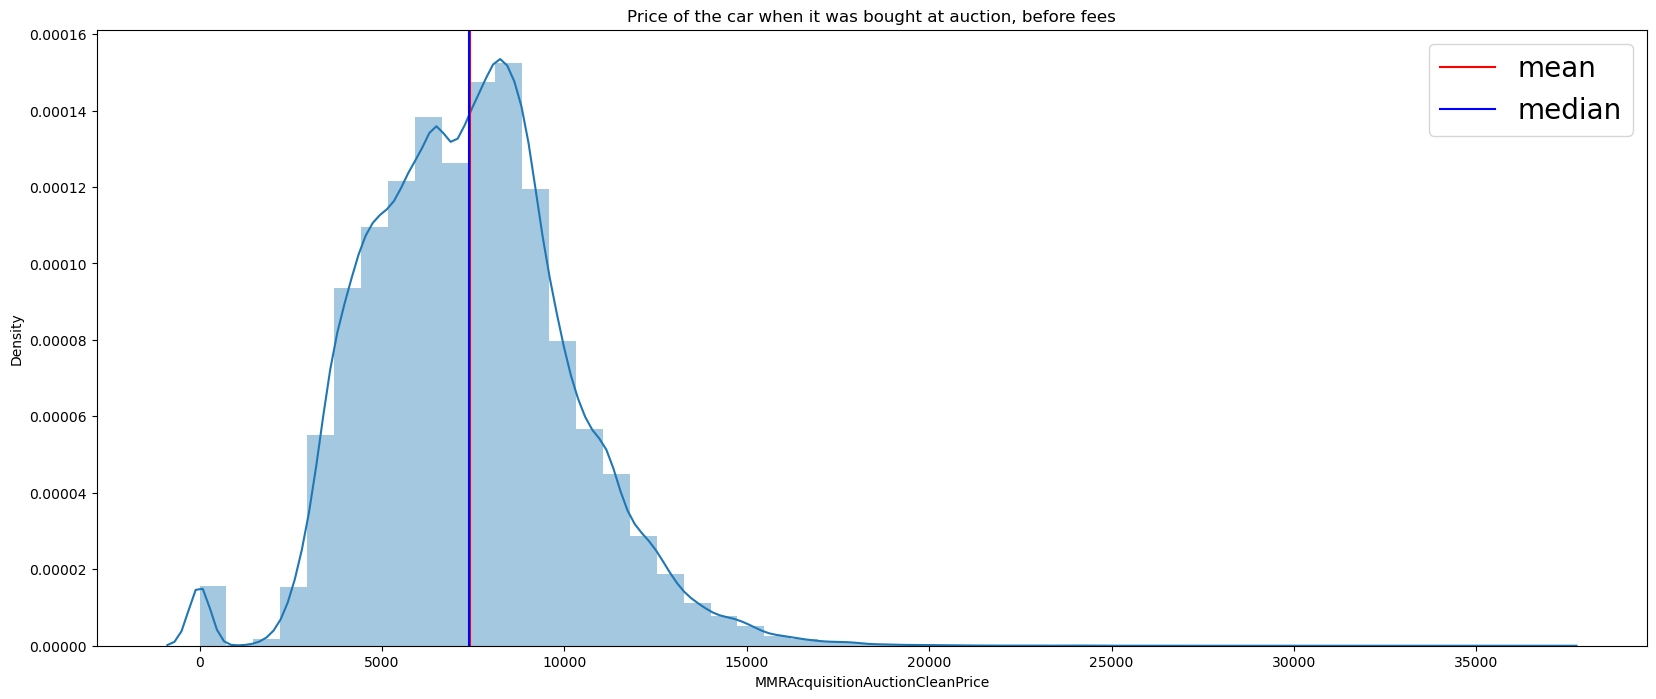

In [31]:
distplot_mean_median(column=car_kick['MMRAcquisitionAuctionCleanPrice'], title="Price of the car when it was bought at auction, before fees")

In [32]:
num_features.append('MMRAcquisitionAuctionCleanPrice')

# MMRAcquisitionRetailAveragePrice - Price of the car when is was bought in a retail store, average

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


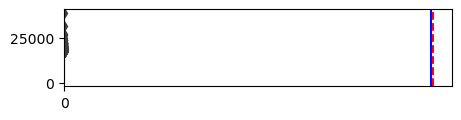

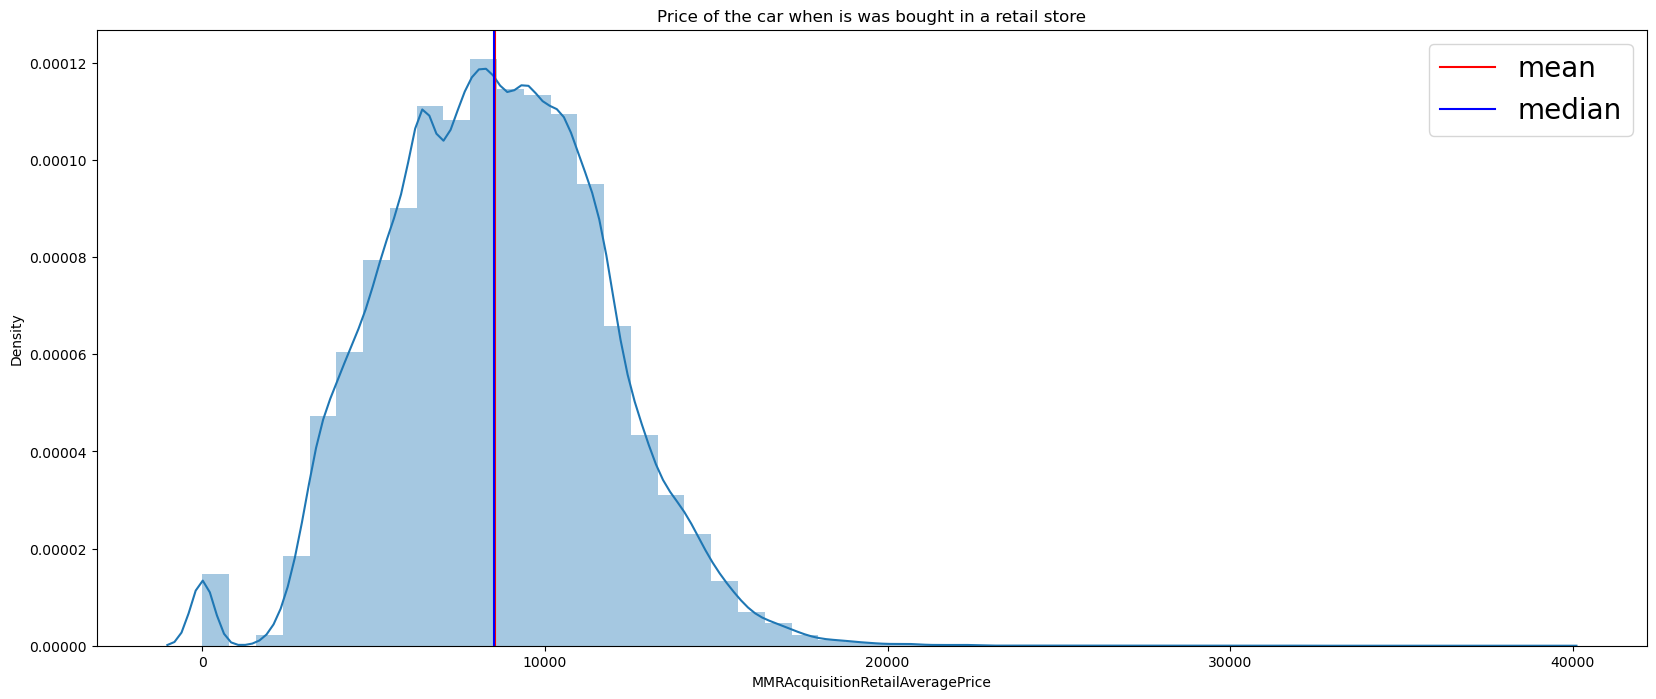

In [33]:
distplot_mean_median(column=car_kick['MMRAcquisitionRetailAveragePrice'], title="Price of the car when is was bought in a retail store")

In [34]:
num_features.append('MMRAcquisitionRetailAveragePrice')

# MMRCurrentAuctionAveragePrice - Current price of the car at auction, average

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


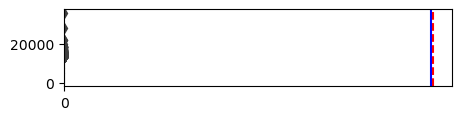

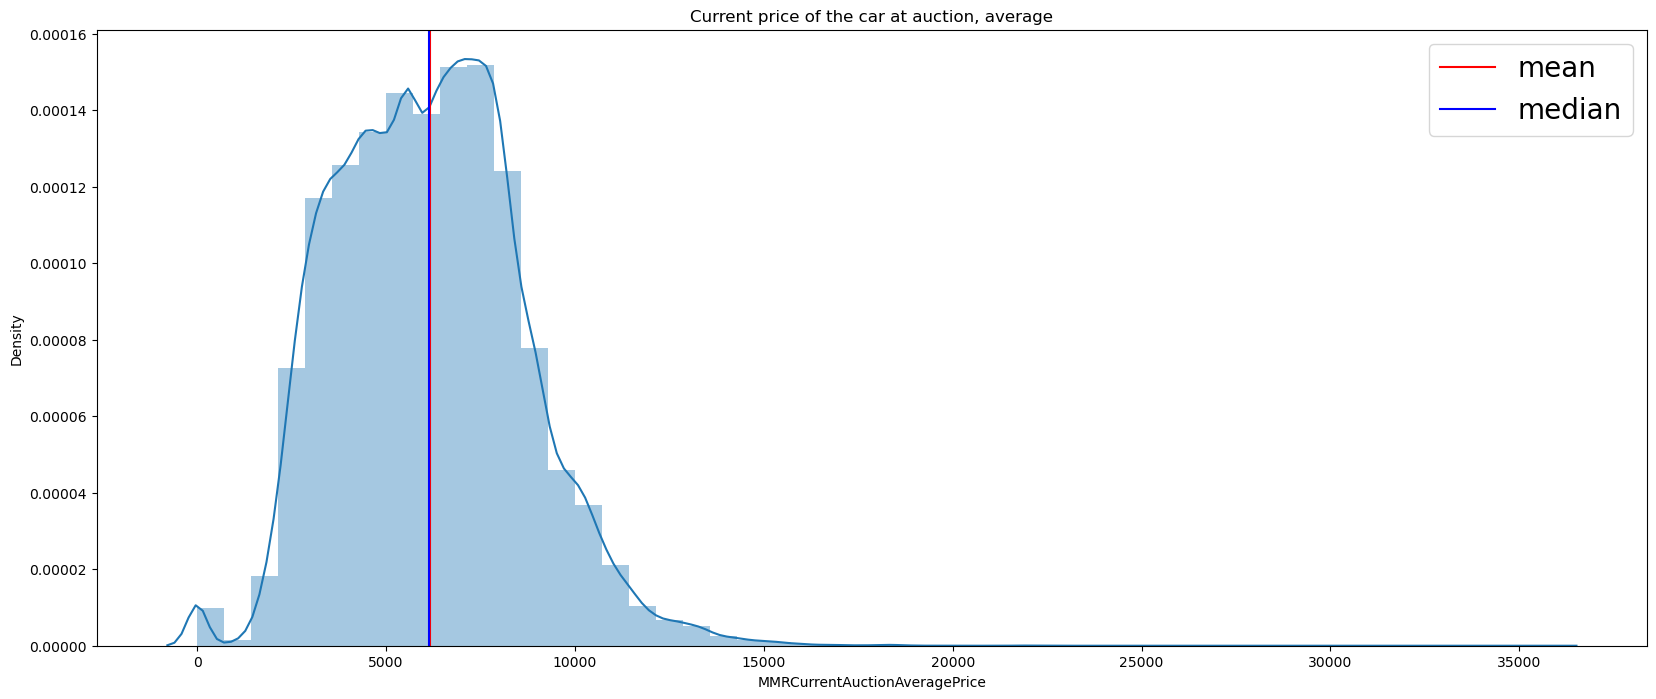

In [35]:
distplot_mean_median(column=car_kick['MMRCurrentAuctionAveragePrice'], title="Current price of the car at auction, average")

In [36]:
num_features.append('MMRCurrentAuctionAveragePrice')

# MMRCurrentRetailAveragePrice - Current price of the car at a retail store, average

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


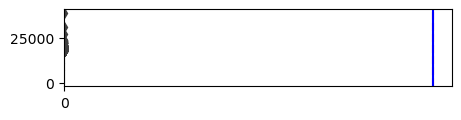

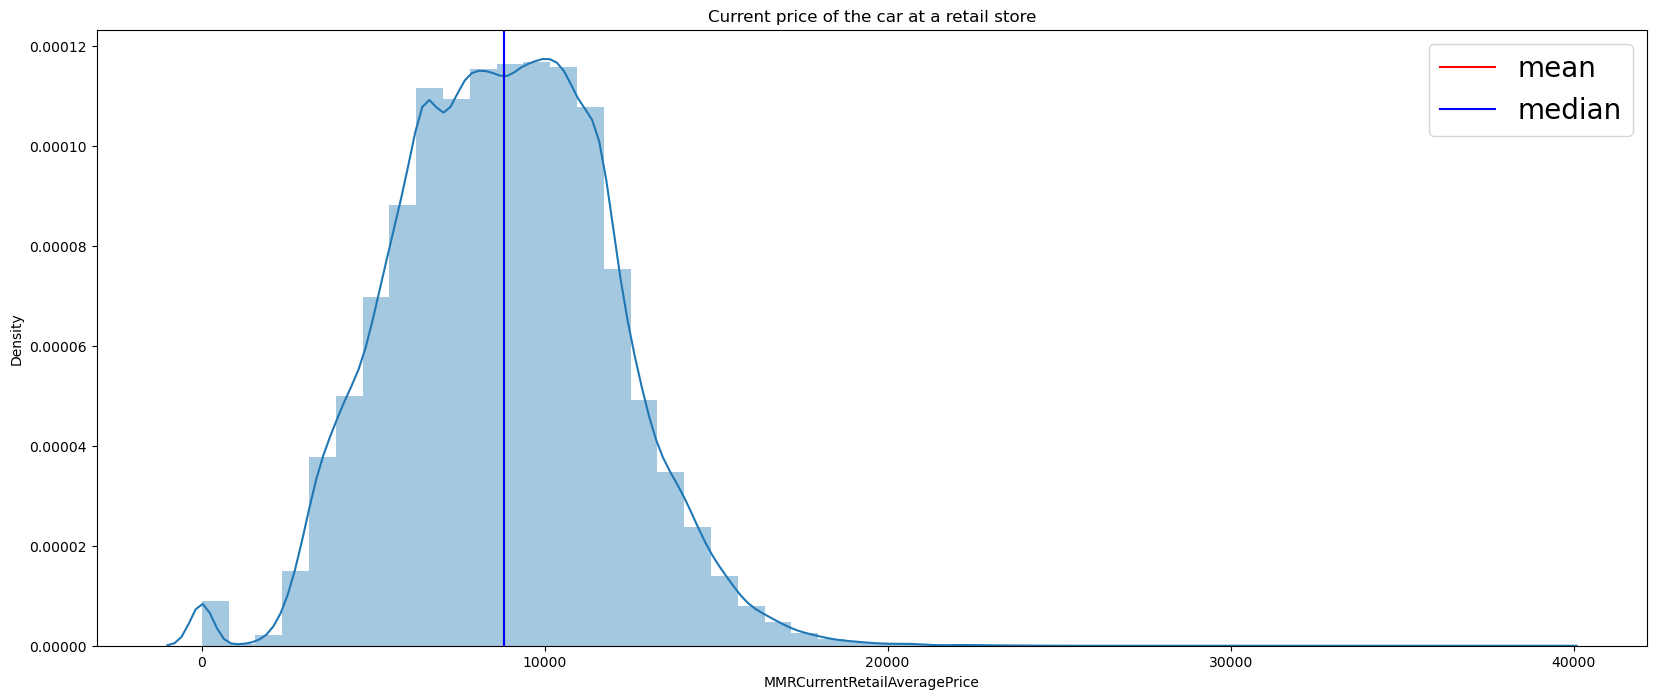

In [37]:
distplot_mean_median(column=car_kick['MMRCurrentRetailAveragePrice'], title="Current price of the car at a retail store")

In [38]:
num_features.append('MMRCurrentRetailAveragePrice')

# VehBCost - B price of the car

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


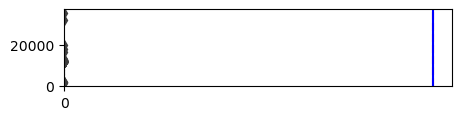

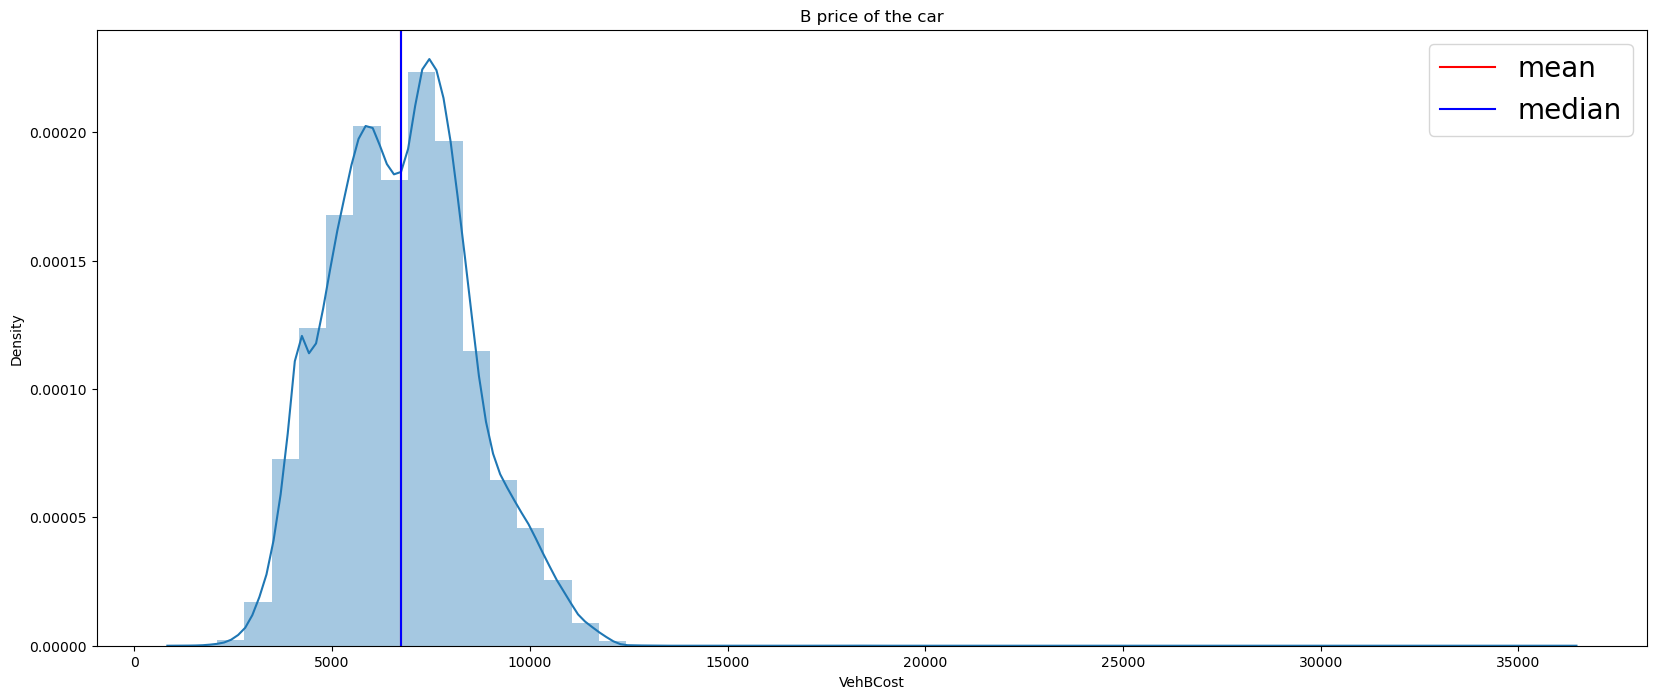

In [39]:
distplot_mean_median(column=car_kick['VehBCost'], title="B price of the car")

In [40]:
num_features.append('VehBCost')

# WarrantyCost - Cost of car warranty

/tmp/ipykernel_95/3756266520.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s = sns.distplot(column)


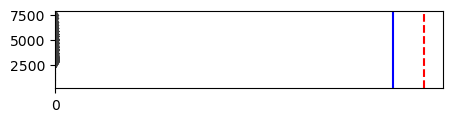

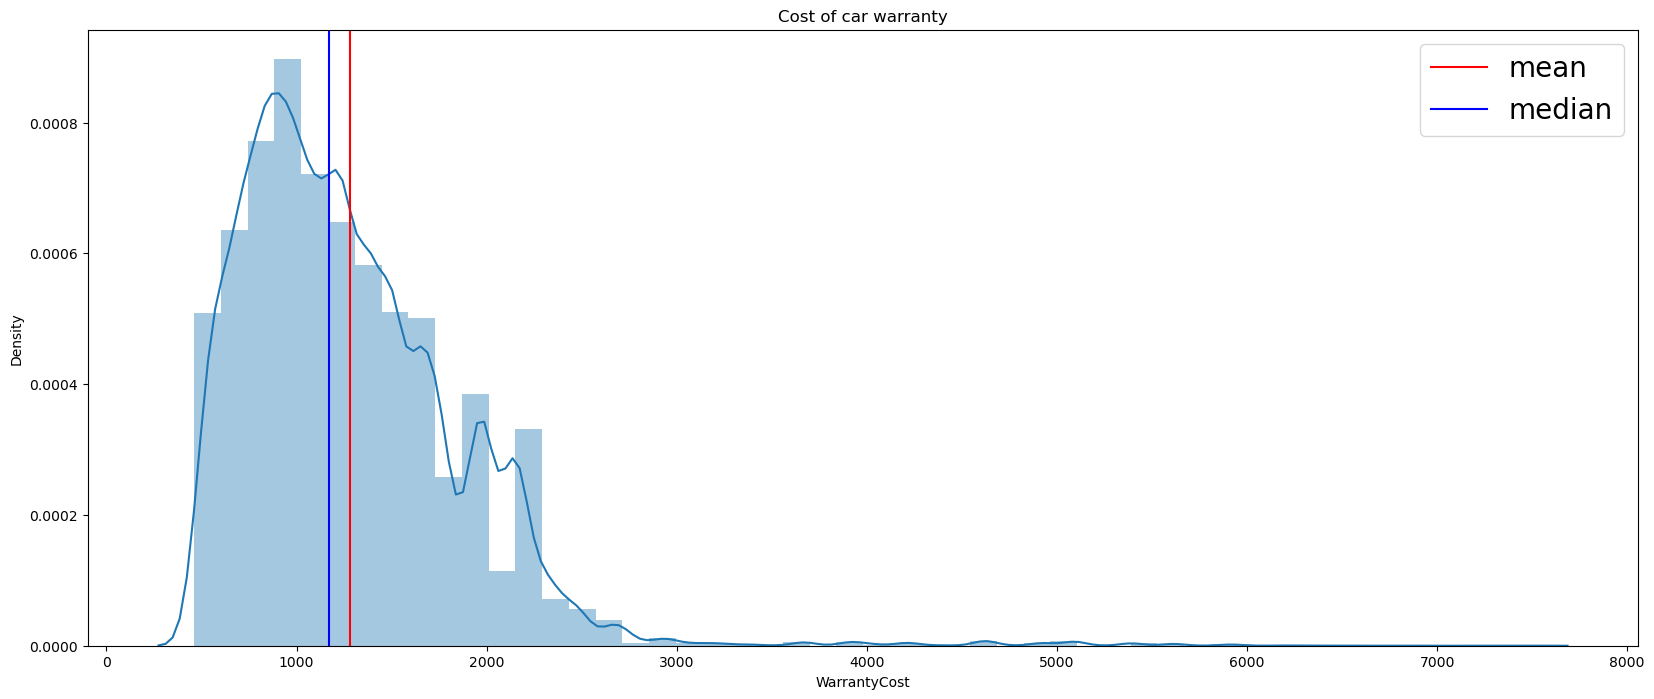

In [41]:
distplot_mean_median(column=car_kick['WarrantyCost'], title="Cost of car warranty")

In [42]:
num_features.append('WarrantyCost')

# Auction - Location of auction

In [43]:
print("Counting of unique location of auction")
print(car_kick['Auction'].value_counts())

Counting of unique location of auction
Auction
MANHEIM    38765
OTHER      15767
ADESA      12679
Name: count, dtype: int64


In [44]:
cat_features.append('Auction')

# Make - Producer of the car

In [45]:
print("Counting of unique producers of cars")
print(car_kick['Make'].value_counts())

Counting of unique producers of cars
Make
CHEVROLET         16517
DODGE             12403
FORD              10687
CHRYSLER           8115
PONTIAC            3783
KIA                2284
NISSAN             1966
HYUNDAI            1707
SATURN             1679
JEEP               1554
TOYOTA             1096
MITSUBISHI          968
MAZDA               882
MERCURY             792
BUICK               676
GMC                 622
HONDA               468
SUZUKI              276
OLDSMOBILE          224
ISUZU               130
VOLKSWAGEN          118
SCION               103
VOLVO                37
LINCOLN              31
SUBARU               25
MINI                 24
ACURA                23
CADILLAC             14
INFINITI              3
PLYMOUTH              2
'TOYOTA SCION'        1
LEXUS                 1
Name: count, dtype: int64


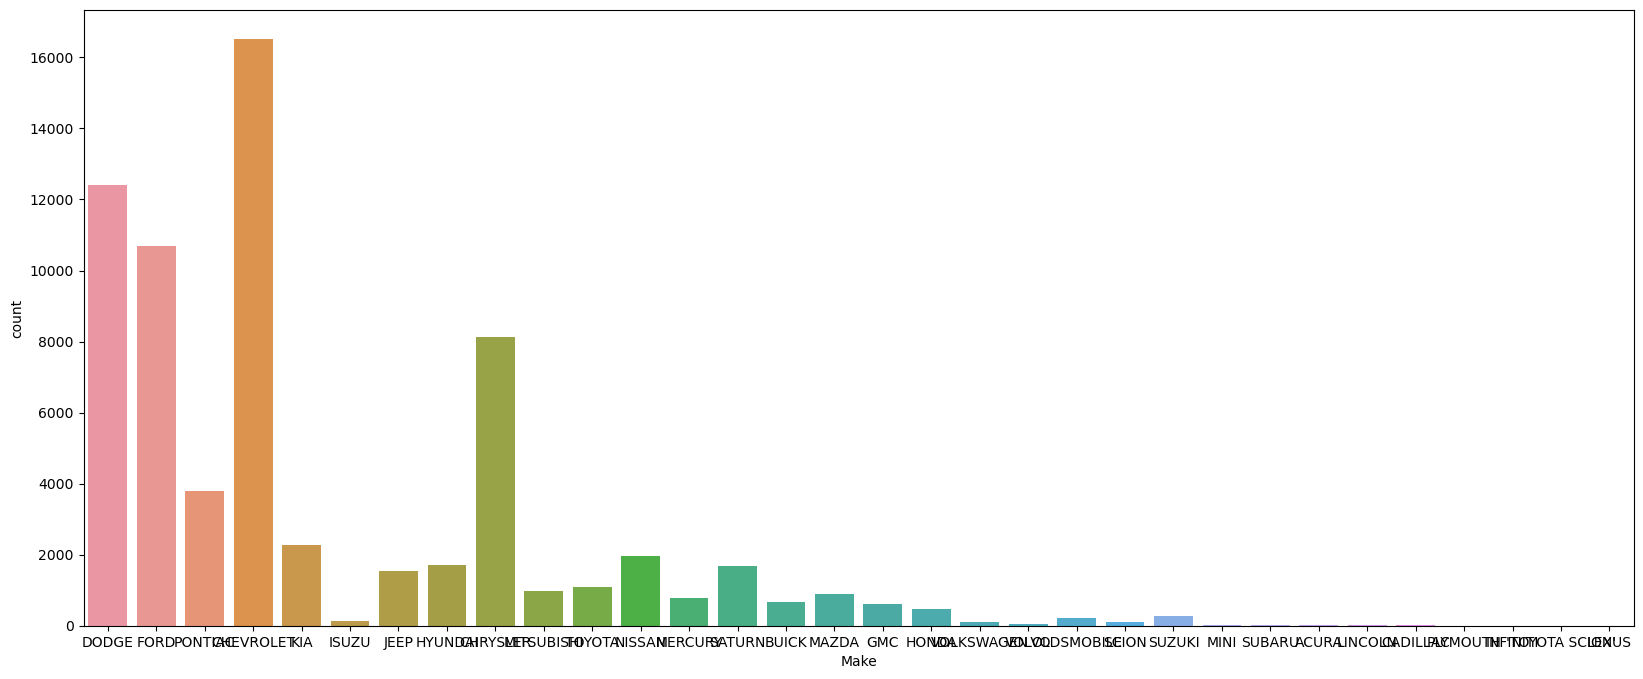

In [46]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Make", data = car_kick)
plt.show()

In [47]:
other = car_kick['Make'].value_counts()[10:].index.tolist()
car_kick['Make'].replace(other,'OTHER', inplace = True)

In [48]:
cat_features.append('Make')

# Model - Model of the car

In [49]:
print("Counting of unique models of cars")
print(car_kick['Model'].value_counts())

Counting of unique models of cars
Model
'PT CRUISER'              2195
IMPALA                    1922
TAURUS                    1369
CALIBER                   1296
'CARAVAN GRAND FWD V6'    1233
                          ... 
'TORRENT FWD V6'             1
'350Z MFI V6 3.5L DOH'       1
'RODEO 2WD 4C MFI I-4'       1
'CONCORDE 3.2L V6 EFI'       1
'ENVOY XL 4WD V8 5.3L'       1
Name: count, Length: 953, dtype: int64


In [50]:
#remoce quotation marks
car_kick["Model"] = car_kick["Model"].replace("""'""", "", regex=True)
# remove special character
car_kick["Model"] = car_kick["Model"].str.replace(' ', '_')

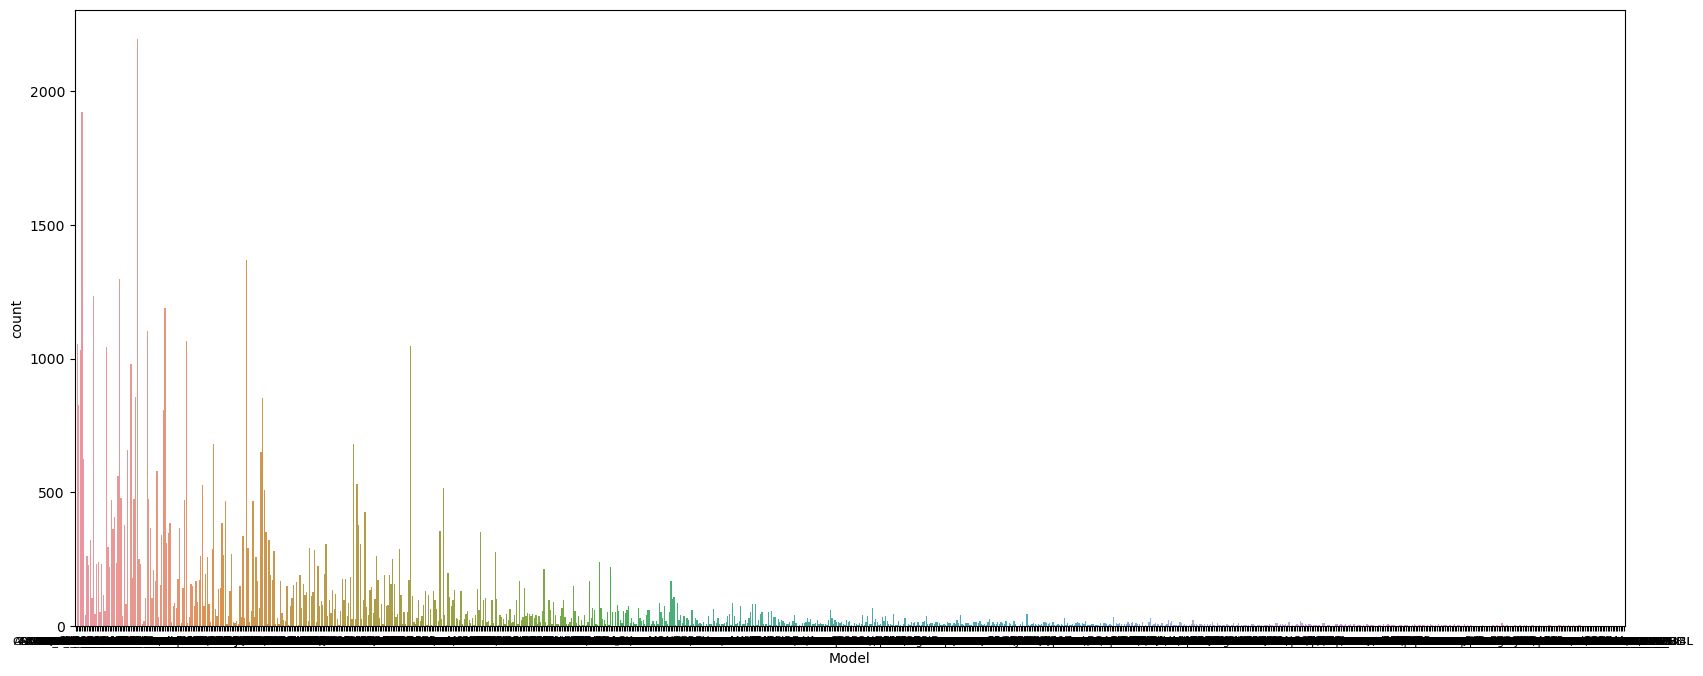

In [51]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Model", data = car_kick)
plt.show()

In [52]:
print("Counting of unique models of cars")
print(car_kick['Model'].value_counts()[:7])

Counting of unique models of cars
Model
PT_CRUISER              2195
IMPALA                  1922
TAURUS                  1369
CALIBER                 1296
CARAVAN_GRAND_FWD_V6    1233
MALIBU_4C               1188
SEBRING_4C              1104
Name: count, dtype: int64


In [53]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

models1 = car_kick['Model'].value_counts()[:10].index.tolist()
models2 = car_kick['Model'].value_counts()[10:25].index.tolist()
models3 = car_kick['Model'].value_counts()[25:50].index.tolist()
models4 = car_kick['Model'].value_counts()[50:80].index.tolist()
models5 = car_kick['Model'].value_counts()[80:150].index.tolist()
models6 = car_kick['Model'].value_counts()[150:].index.tolist()

car_kick['Model'].replace(models1, "6", inplace = True)
car_kick['Model'].replace(models2, "5", inplace = True)
car_kick['Model'].replace(models3,"4", inplace = True)
car_kick['Model'].replace(models4, "3", inplace = True)
car_kick['Model'].replace(models5,"2", inplace = True)
car_kick['Model'].replace(models6,"1", inplace = True)
car_kick['Model'].value_counts()

Model
6    13477
1    12995
5    11364
2    10639
4    10581
3     8155
Name: count, dtype: int64

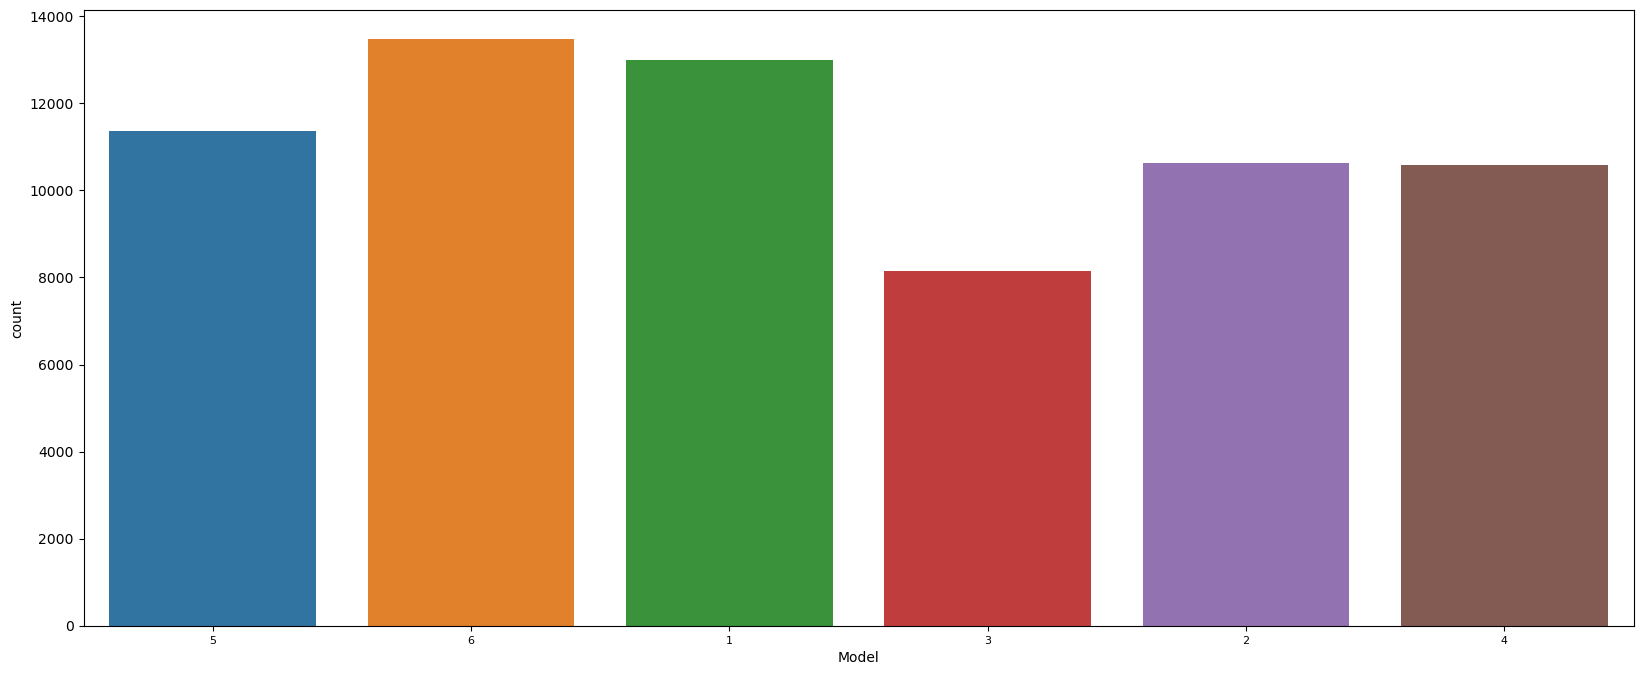

In [54]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Model", data = car_kick)
plt.show()

In [55]:
cat_features.append('Model')

# Trim - Trim level of the car

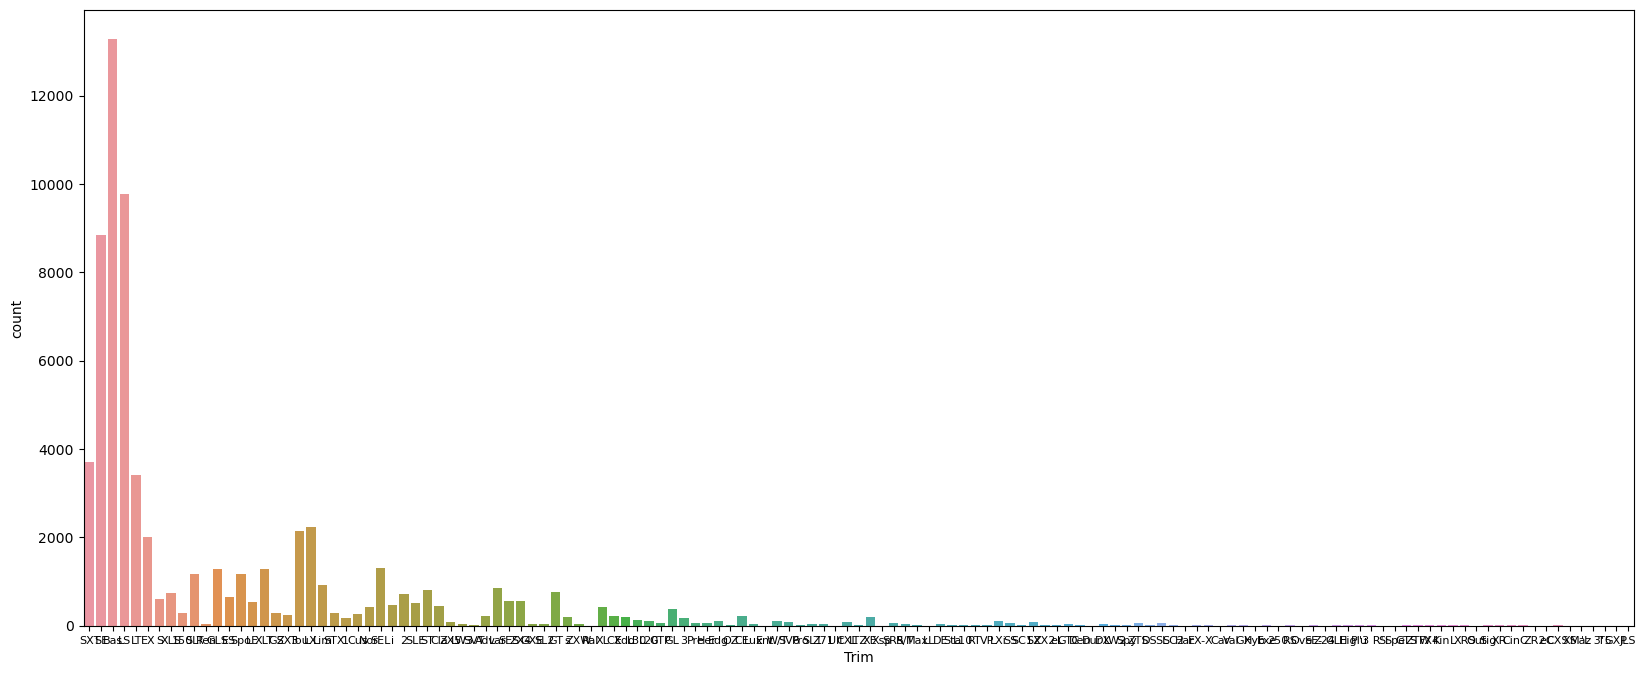

In [56]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Trim", data = car_kick)
plt.show()

In [57]:
print("Counting of unique levels of cars")
print(car_kick['Trim'].value_counts()[80:100])

Counting of unique levels of cars
Trim
L10      18
GLE      16
SC1      15
Max      15
X        14
OZ       13
ZX2      12
Pro      12
FX4      11
Kin      10
Sig      10
SVT       9
eL        8
CXS       8
GTS       7
'3 R'     7
Hig       7
L         7
RT        7
XRS       7
Name: count, dtype: int64


In [58]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

lvl1 = car_kick['Trim'].value_counts()[:3].index.tolist()
lvl2 = car_kick['Trim'].value_counts()[3:10].index.tolist()
lvl3 = car_kick['Trim'].value_counts()[10:25].index.tolist()
lvl4 = car_kick['Trim'].value_counts()[25:50].index.tolist()
lvl5 = car_kick['Trim'].value_counts()[50:].index.tolist()

car_kick['Trim'].replace(lvl1, "5", inplace = True)
car_kick['Trim'].replace(lvl2, "4", inplace = True)
car_kick['Trim'].replace(lvl3,"3", inplace = True)
car_kick['Trim'].replace(lvl4, "2", inplace = True)
car_kick['Trim'].replace(lvl5,"1", inplace = True)
car_kick['Trim'].value_counts()

Trim
5    31891
2    17706
4    16092
1     1522
Name: count, dtype: int64

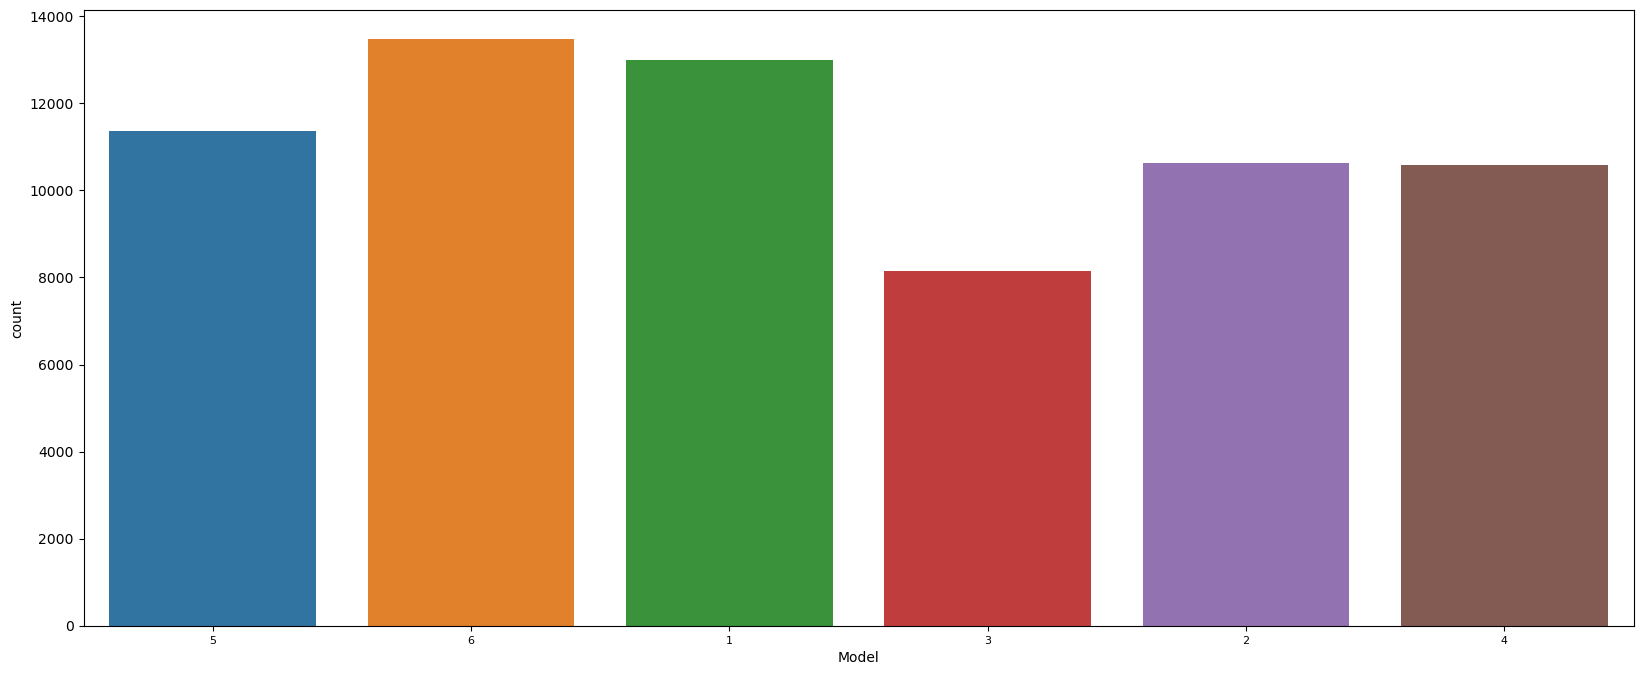

In [59]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Model", data = car_kick)
plt.show()

In [60]:
cat_features.append('Trim')

# SubModel - Submodel of the car

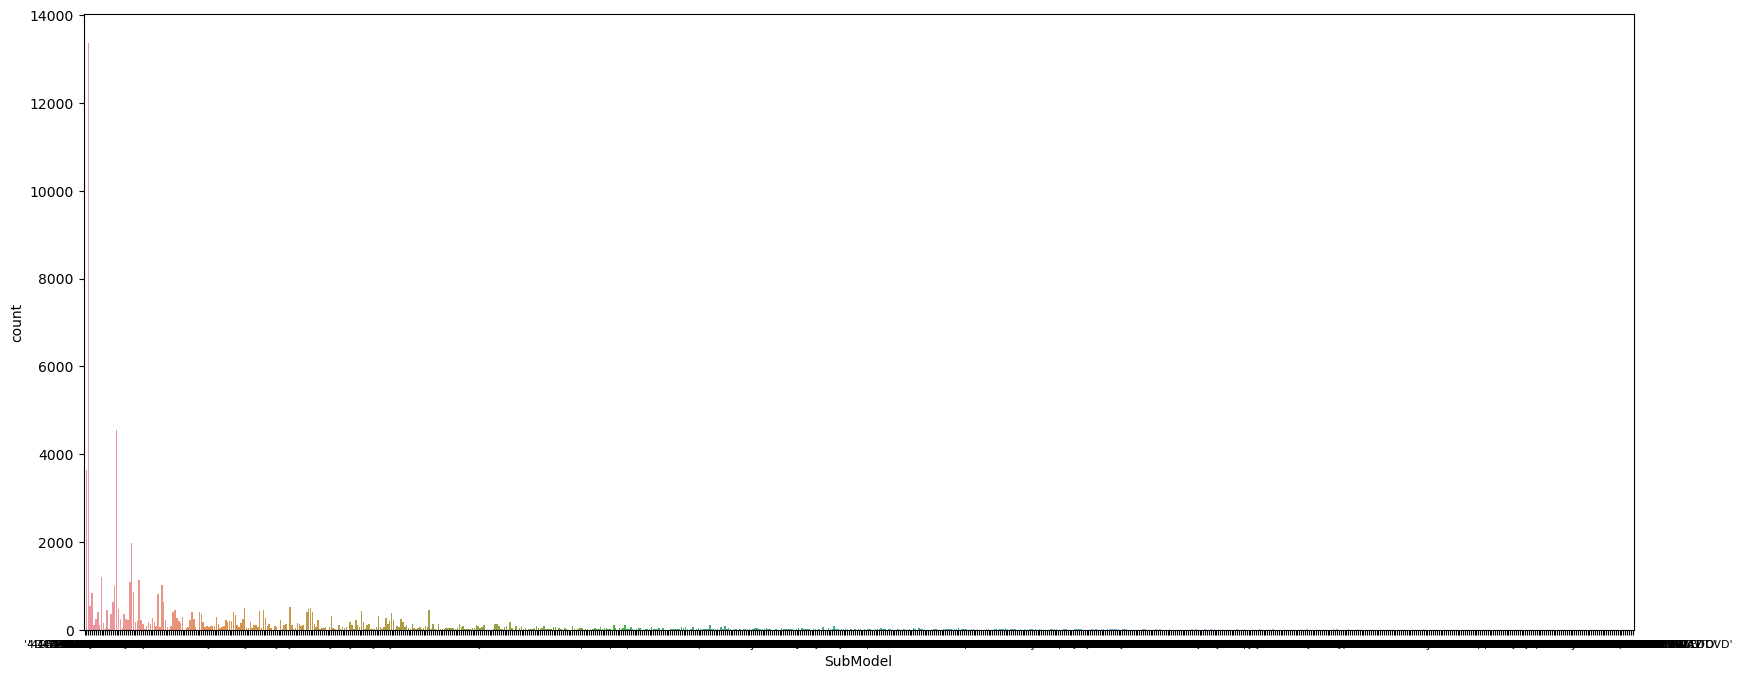

In [61]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "SubModel", data = car_kick)
plt.show()

In [62]:
print("Counting of unique submodels of cars")
print(car_kick['SubModel'].value_counts()[:10])

Counting of unique submodels of cars
SubModel
'4D SEDAN'            13363
'4D SEDAN LS'          4541
'4D SEDAN SE'          3648
'4D WAGON'             1979
'MINIVAN 3.3L'         1203
'4D SUV 4.2L LS'       1137
'4D SEDAN LT'          1094
'4D SEDAN SXT FFV'     1090
'4D SEDAN LX'          1022
'2D COUPE'              997
Name: count, dtype: int64


In [63]:
#remoce quotation marks
car_kick["SubModel"] = car_kick["SubModel"].replace("""'""", "", regex=True)
# remove special character
car_kick["SubModel"] = car_kick["SubModel"].str.replace(' ', '_')

In [64]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

models0 = car_kick['SubModel'].value_counts()[1:5].index.tolist()
models1 = car_kick['SubModel'].value_counts()[5:10].index.tolist()
models2 = car_kick['SubModel'].value_counts()[10:25].index.tolist()
models3 = car_kick['SubModel'].value_counts()[25:50].index.tolist()
models4 = car_kick['SubModel'].value_counts()[50:80].index.tolist()
models5 = car_kick['SubModel'].value_counts()[80:150].index.tolist()
models6 = car_kick['SubModel'].value_counts()[150:].index.tolist()

car_kick['SubModel'].replace(models0, "7", inplace = True)
car_kick['SubModel'].replace(models1, "6", inplace = True)
car_kick['SubModel'].replace(models2, "5", inplace = True)
car_kick["SubModel"].replace(models3,"4", inplace = True)
car_kick['SubModel'].replace(models4, "3", inplace = True)
car_kick['SubModel'].replace(models5,"2", inplace = True)
car_kick['SubModel'].replace(models6,"1", inplace = True)
car_kick['SubModel'].value_counts()

SubModel
4D_SEDAN    13363
7           11371
5            8557
4            8472
1            7361
2            6832
3            5915
6            5340
Name: count, dtype: int64

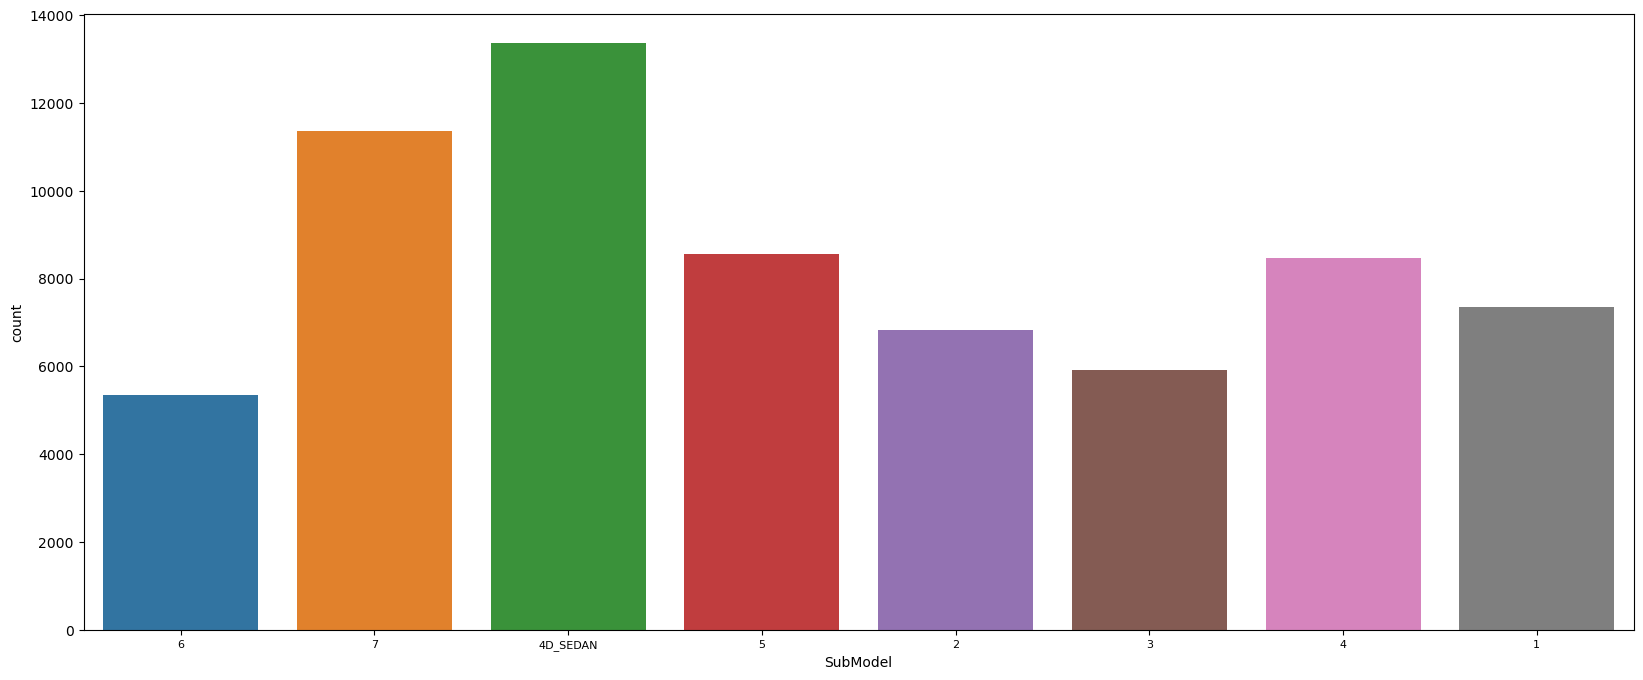

In [65]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "SubModel", data = car_kick)
plt.show()

In [66]:
cat_features.append('SubModel')

# Color - Color of the car

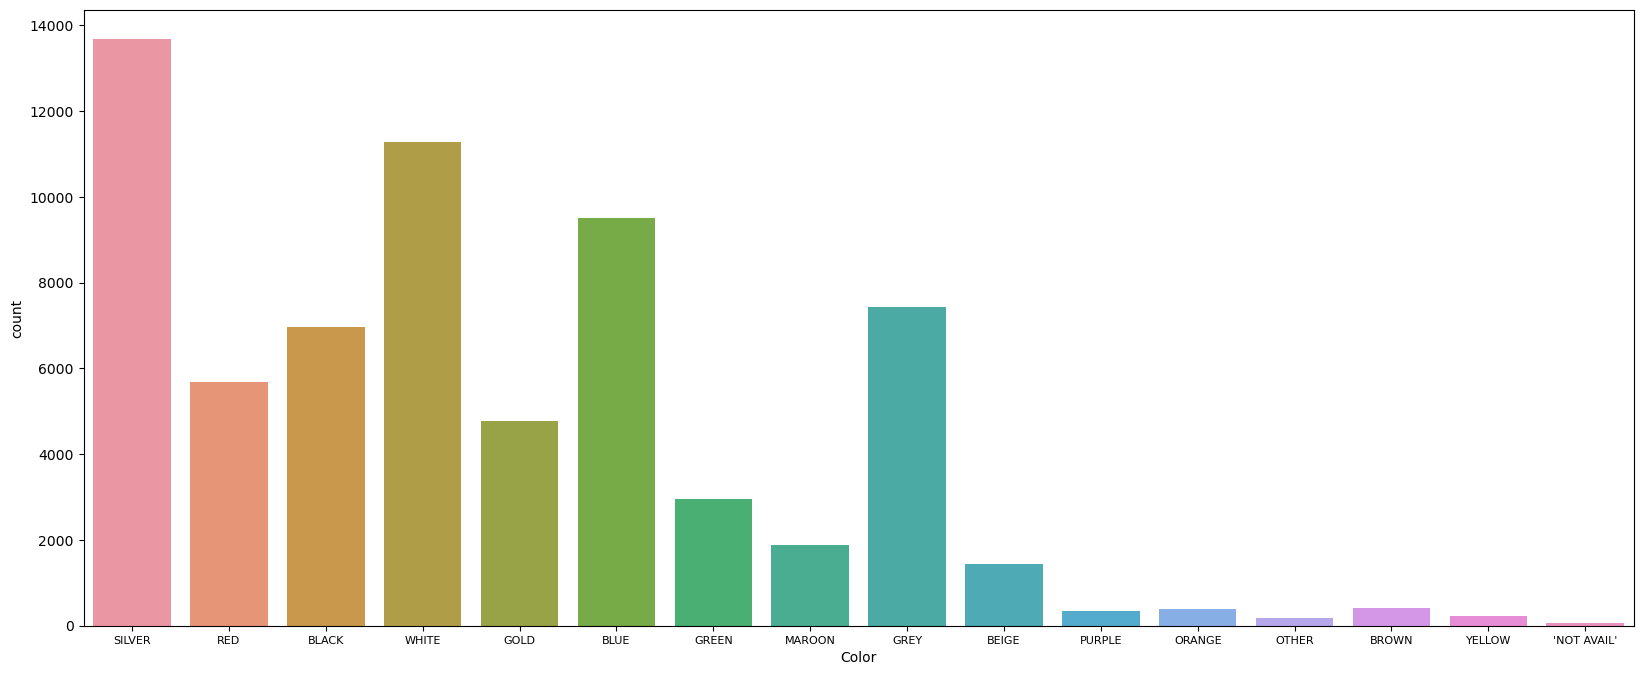

In [67]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Color", data = car_kick)
plt.show()

In [68]:
print("Counting of unique color of cars")
print(car_kick['Color'].value_counts())

Counting of unique color of cars
Color
SILVER         13683
WHITE          11285
BLUE            9515
GREY            7422
BLACK           6965
RED             5678
GOLD            4767
GREEN           2961
MAROON          1888
BEIGE           1435
BROWN            416
ORANGE           381
PURPLE           347
YELLOW           233
OTHER            175
'NOT AVAIL'       60
Name: count, dtype: int64


In [69]:
other = car_kick['Color'].value_counts()[10:].index.tolist()
car_kick['Color'].replace(other, "OTHER", inplace = True)

In [70]:
cat_features.append('Color')

# Transmission - Type of transmission in the car

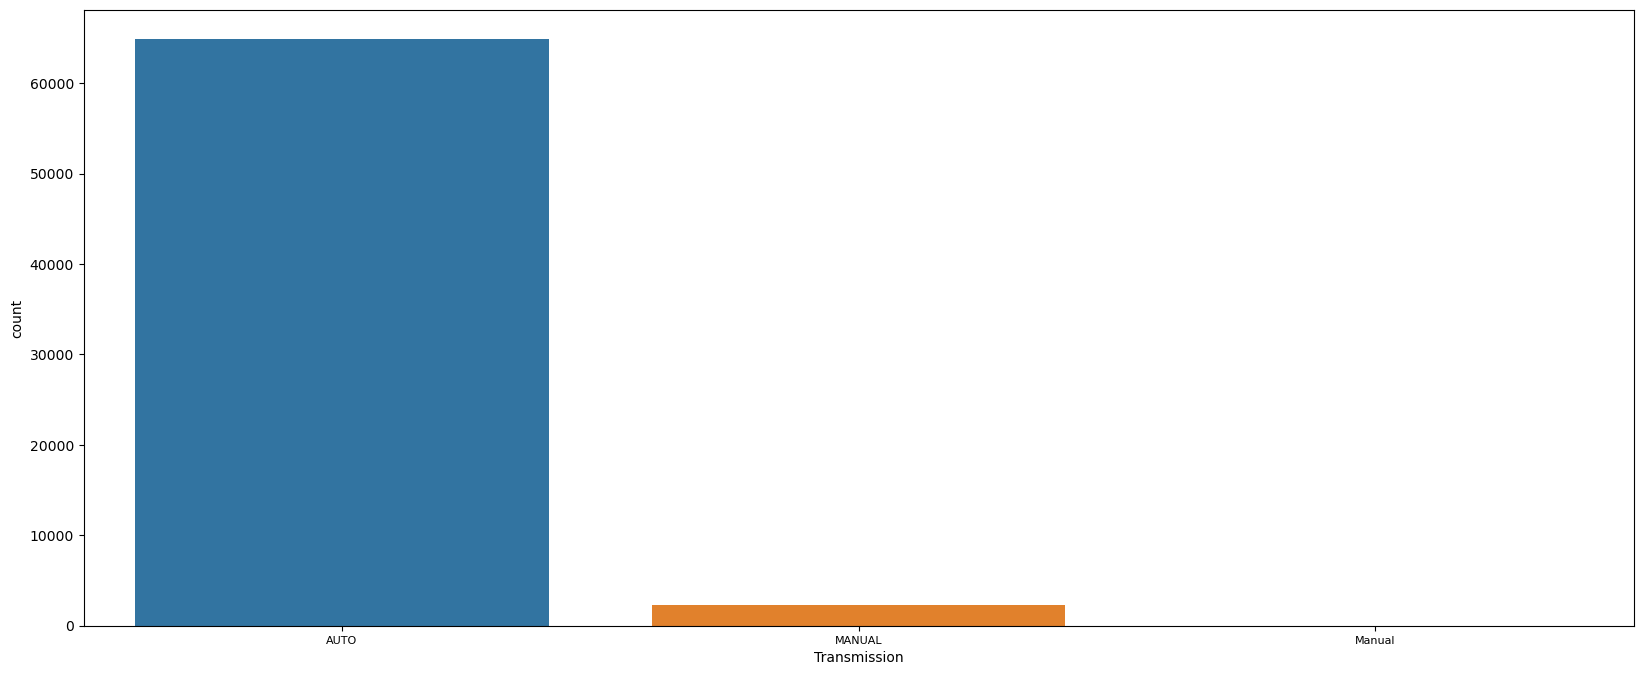

In [71]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Transmission", data = car_kick)
plt.show()

In [72]:
car_kick['Transmission'].replace("Manual", "MANUAL", inplace = True)

In [73]:
cat_features.append('Transmission')

# WheelTypeID - ID of the wheelID

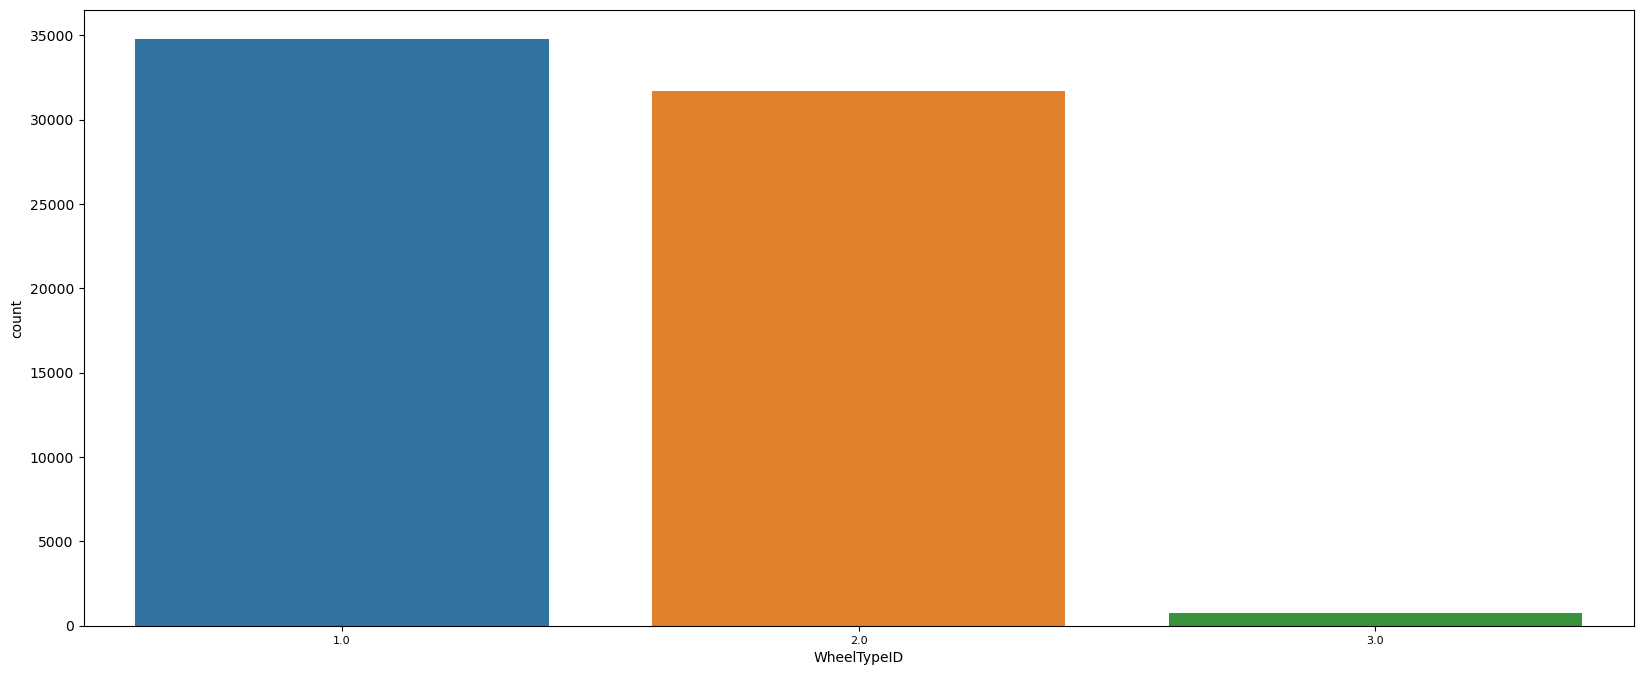

In [74]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "WheelTypeID", data = car_kick)
plt.show()

In [75]:
#change to int
car_kick['WheelTypeID'] = car_kick['WheelTypeID'].astype(int)

In [76]:
cat_features.append('WheelTypeID')

# WheelType - Type of wheel

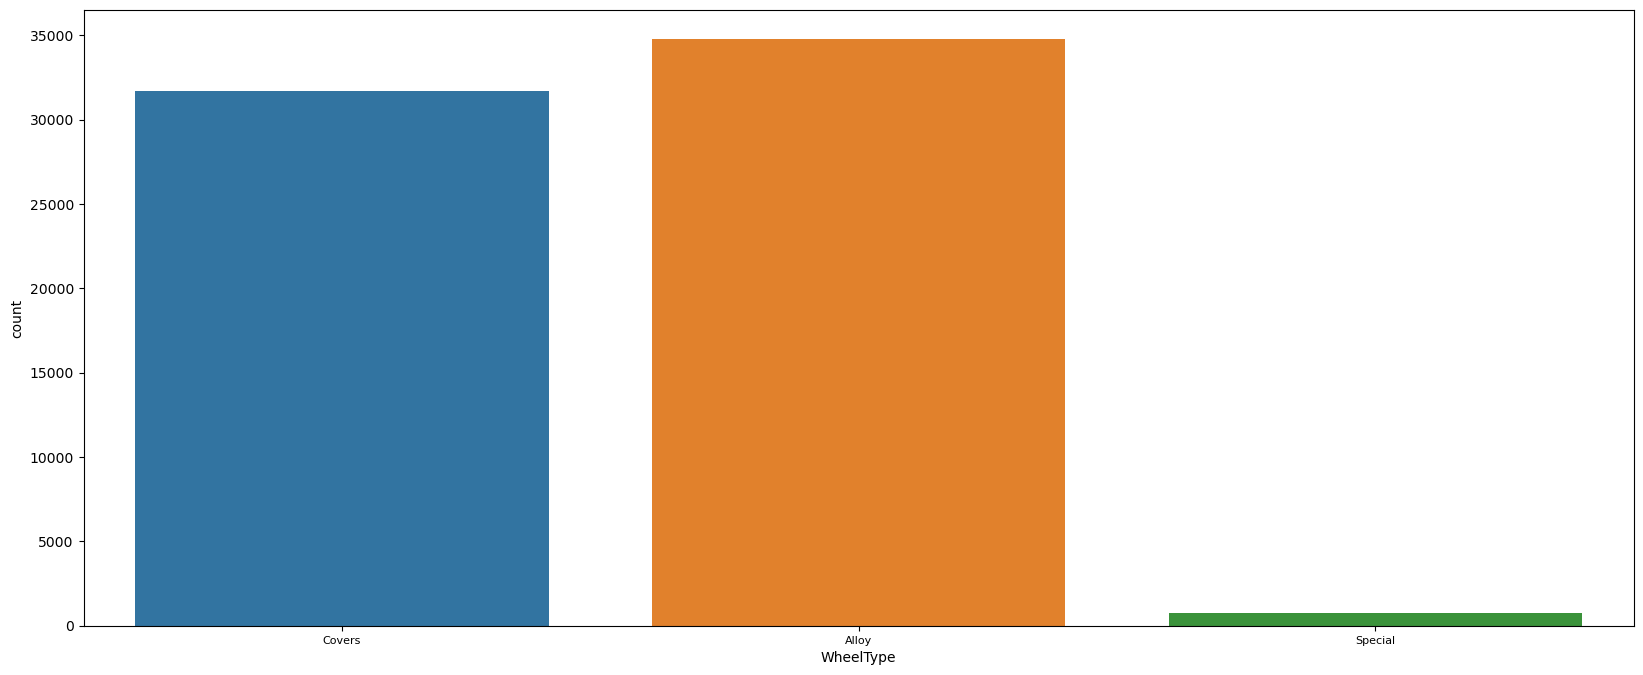

In [77]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "WheelType", data = car_kick)
plt.show()

In [78]:
cat_features.append('WheelType')

# Nationality - Nationality of the car

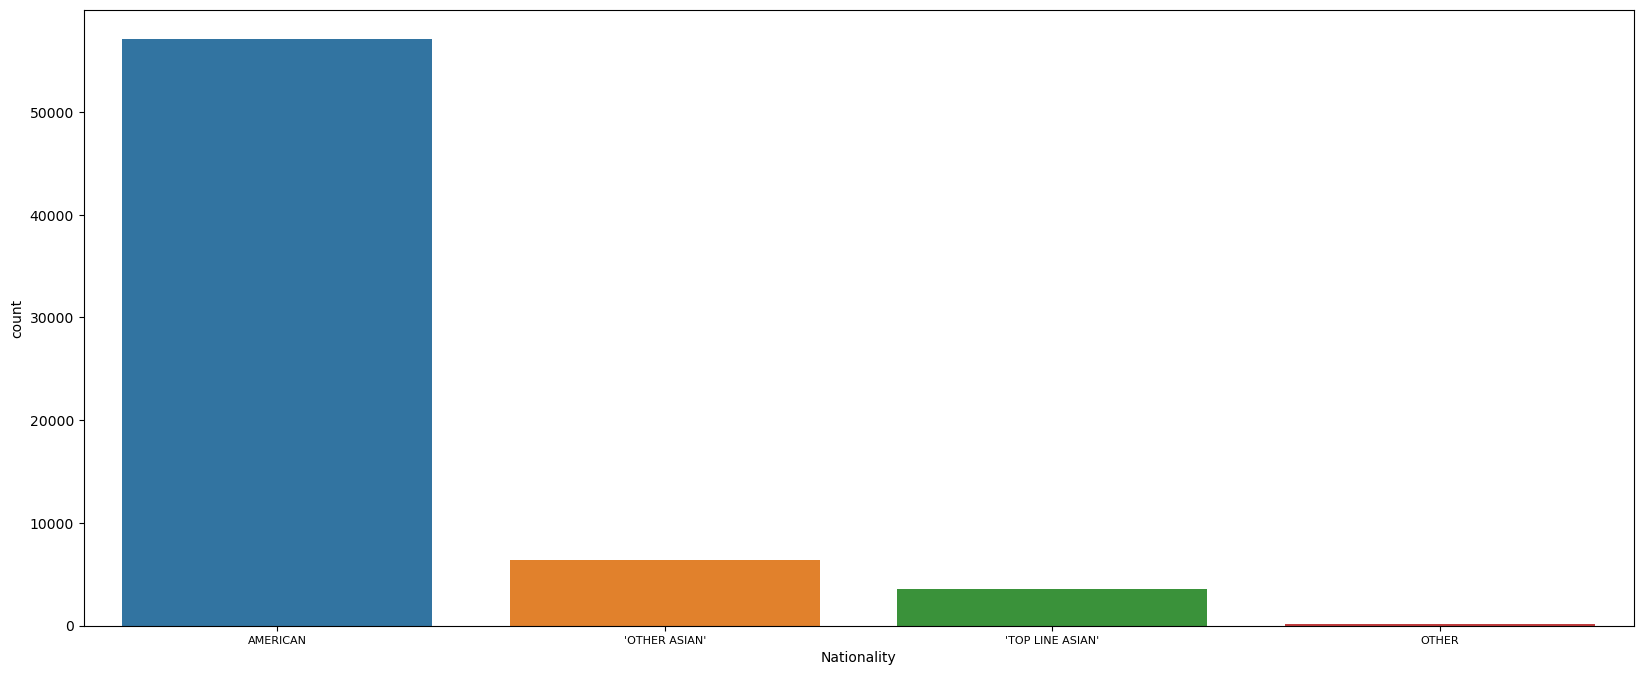

In [79]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Nationality", data = car_kick)
plt.show()

In [80]:
other = car_kick['Nationality'].value_counts()[1:].index.tolist()
car_kick['Nationality'].replace(other, "OTHER", inplace = True)

In [81]:
cat_features.append('Nationality')

# Size - Size of the car

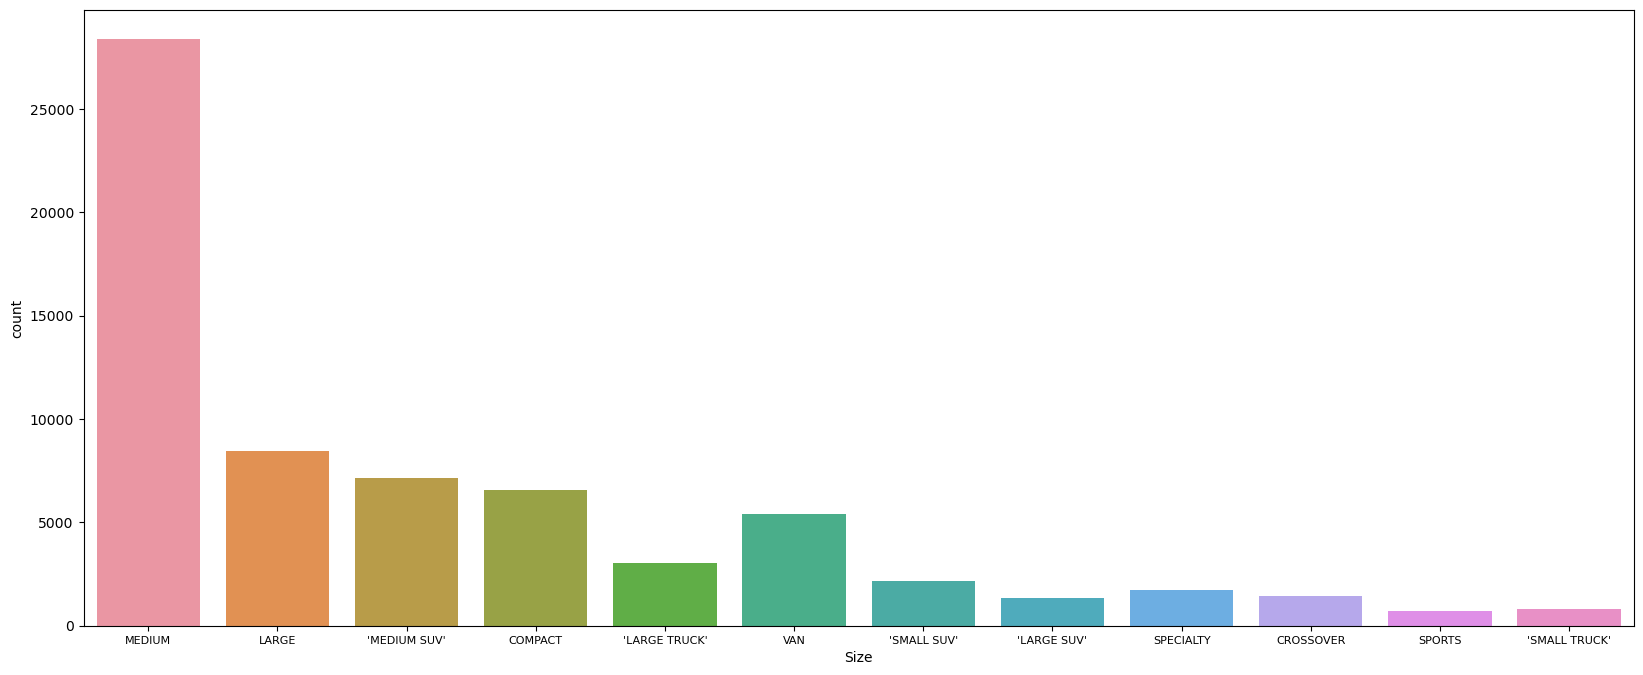

In [82]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Size", data = car_kick)
plt.show()

In [83]:
#remoce quotation marks
car_kick["Size"] = car_kick["Size"].replace("""'""", "", regex=True)
# remove special character
car_kick["Size"] = car_kick["Size"].str.replace(' ', '_')

In [84]:
car_kick['Size'].replace(["LARGE", "LARGE_TRUCK", "LARGE_SUV"], "LARGE", inplace = True)
car_kick['Size'].replace(["SMALL_SUV", "SMALL_TRUCK", "SPORTS"], "SMALL", inplace = True)
car_kick['Size'].replace(["SPECIALTY", "CROSSOVER"], "OTHER", inplace = True)

car_kick['Size'].value_counts()

Size
MEDIUM        28375
LARGE         12830
MEDIUM_SUV     7149
COMPACT        6546
VAN            5422
SMALL          3709
OTHER          3180
Name: count, dtype: int64

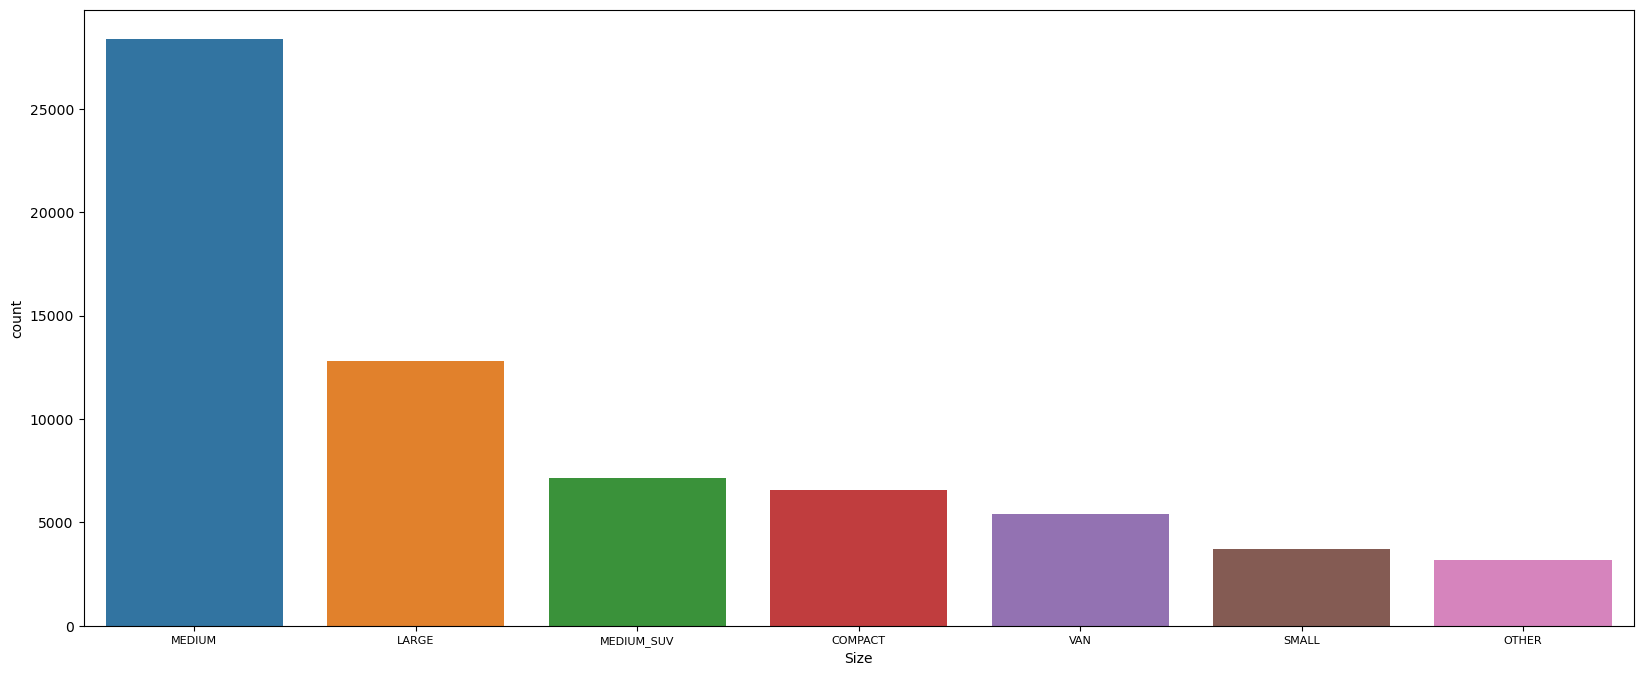

In [85]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "Size", data = car_kick)
plt.show()

In [86]:
cat_features.append('Size')

In [87]:
# TopThreeAmericanName -Whether the car is from one of the three largest manufacturers in America

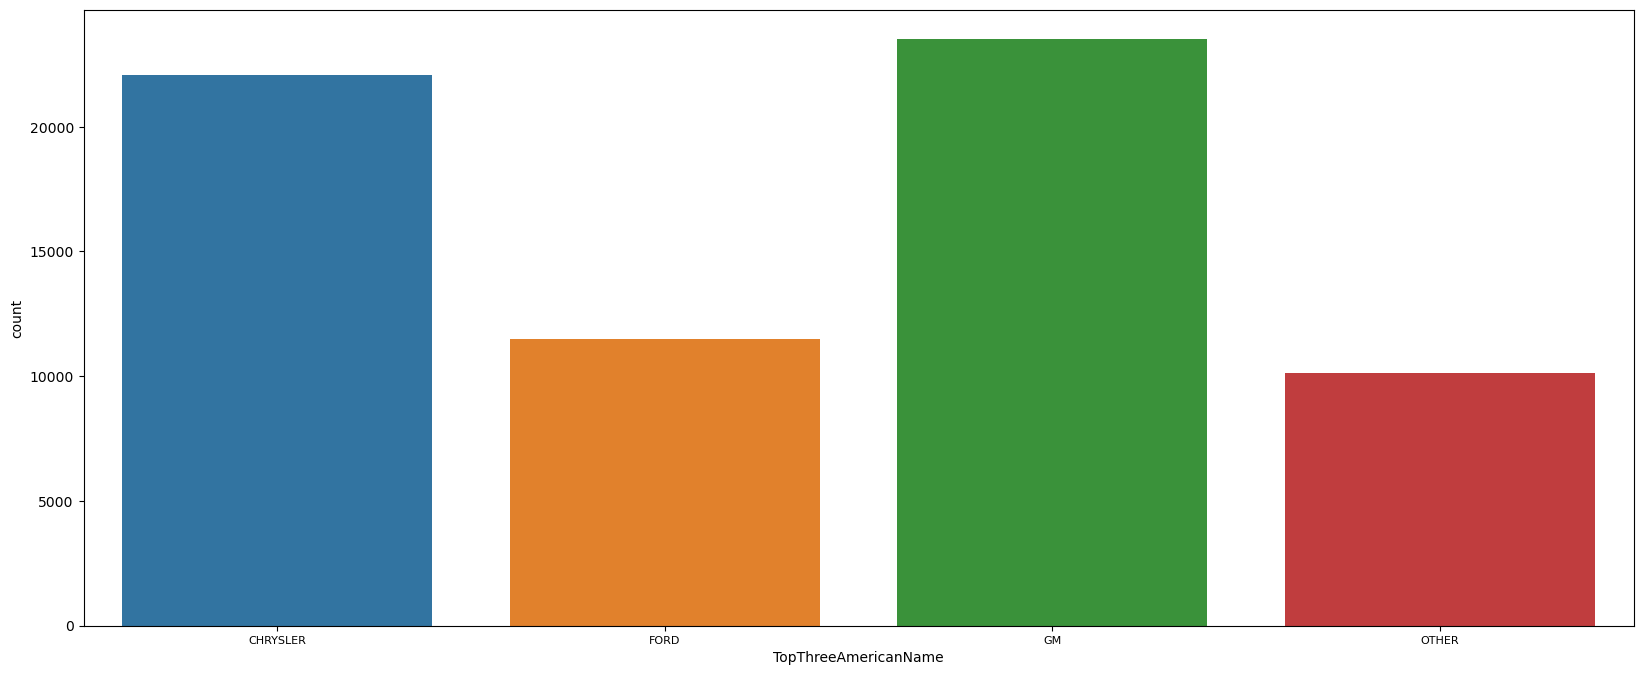

In [88]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "TopThreeAmericanName", data = car_kick)
plt.show()

In [89]:
cat_features.append('TopThreeAmericanName')

# BYRNO -Car registration number

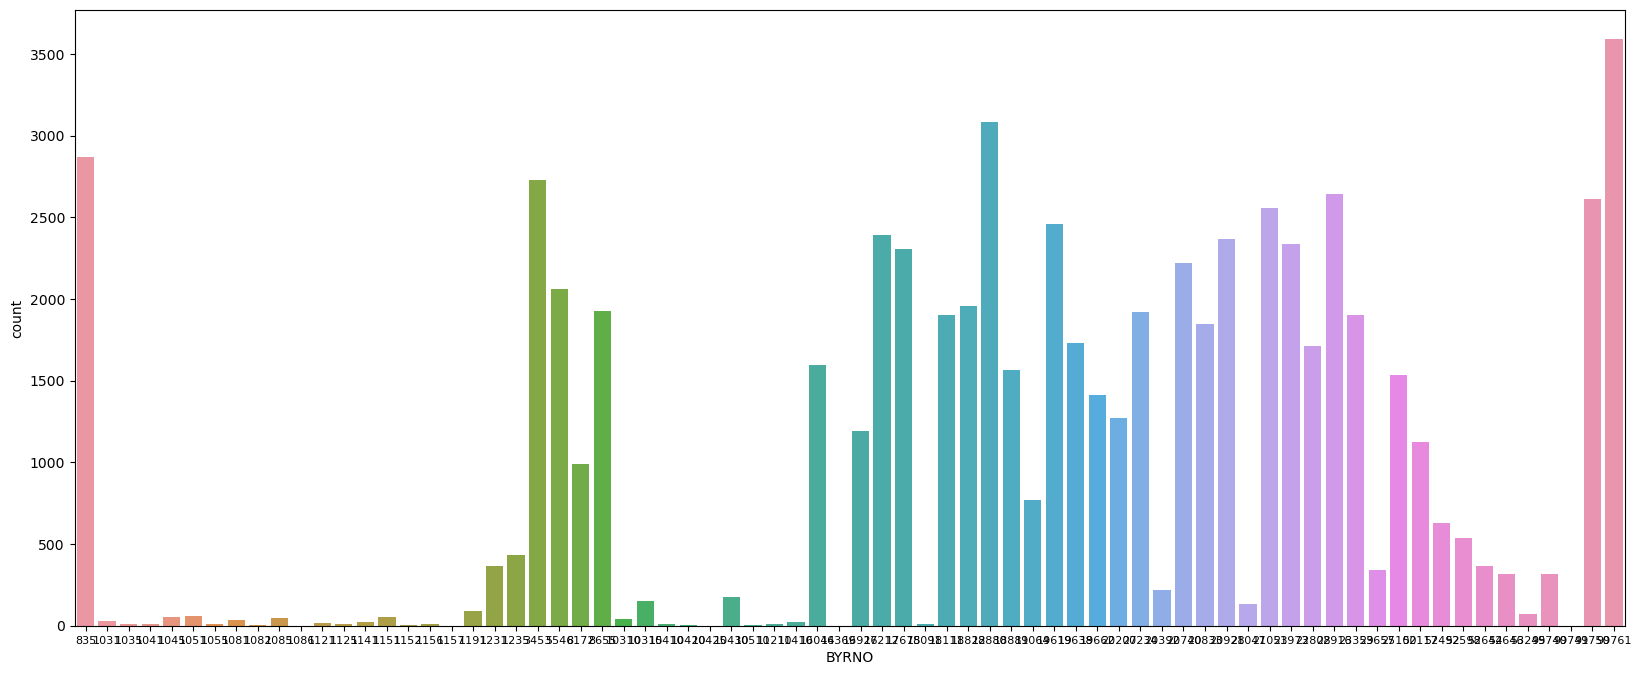

In [90]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "BYRNO", data = car_kick)
plt.show()

In [91]:
print("Counting of unique registration number")
print(car_kick['BYRNO'].value_counts())

Counting of unique registration number
BYRNO
99761    3591
18880    3082
835      2870
3453     2729
22916    2641
         ... 
1086        1
1157        1
10425       1
99741       1
16369       1
Name: count, Length: 72, dtype: int64


In [92]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

other = car_kick['BYRNO'].value_counts()[40:].index.tolist()
car_kick['BYRNO'].replace(other, "OTHER", inplace = True)

In [93]:
cat_features.append('BYRNO')

# VNZIP1 - Car ZIP number

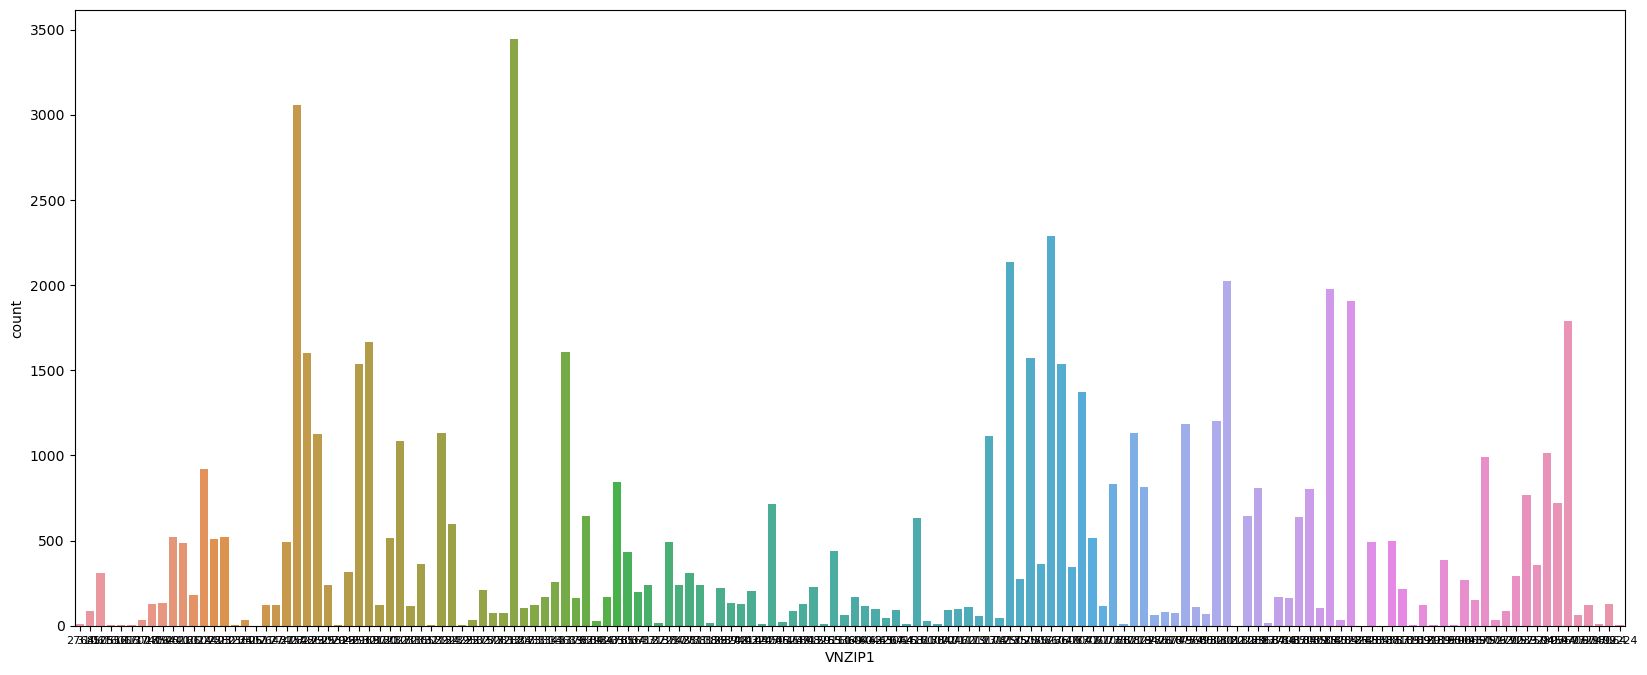

In [94]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "VNZIP1", data = car_kick)
plt.show()

In [95]:
print("Counting of unique ZIP number")
print(car_kick['VNZIP1'].value_counts()[30:])

Counting of unique ZIP number
VNZIP1
92337    765
94544    722
45005    713
33809    644
80229    643
        ... 
16137      2
80112      1
25071      1
85248      1
85338      1
Name: count, Length: 120, dtype: int64


In [96]:
car_kick['VNZIP1'] = car_kick['VNZIP1'].apply(lambda x: str(x)[:2])

In [97]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

other = car_kick['VNZIP1'].value_counts()[40:].index.tolist()
car_kick['VNZIP1'].replace(other, "OTHER", inplace = True)

In [98]:
cat_features.append('VNZIP1')

# VNST - Car navigation system

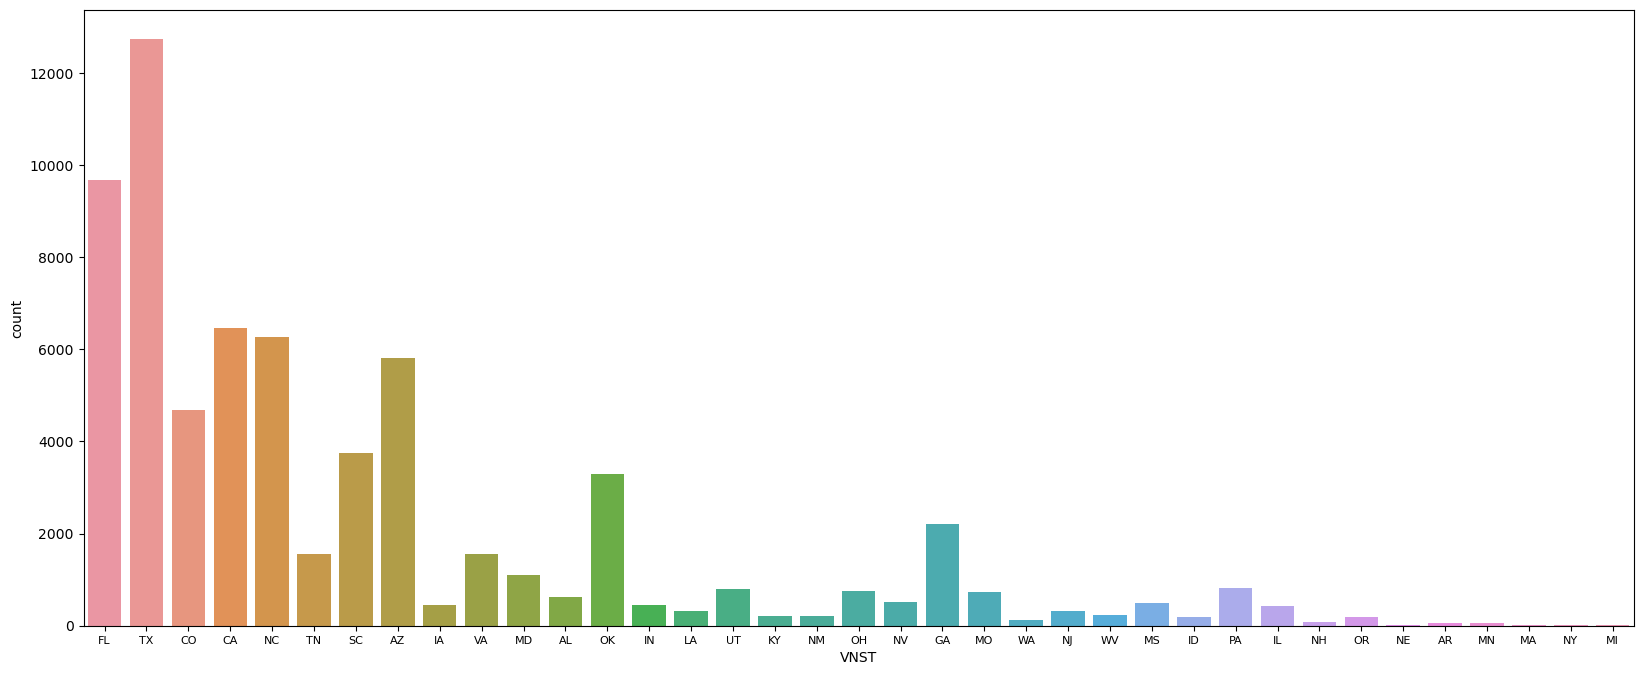

In [99]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "VNST", data = car_kick)
plt.show()

In [100]:
#There is a lot of diffrent models in the data, it would be good to split it into more general categories

other = car_kick['VNST'].value_counts()[10:].index.tolist()
car_kick['VNST'].replace(other, "OTHER", inplace = True)

In [101]:
cat_features.append('VNST')

# IsOnlineSale - Whether the sale was online or not

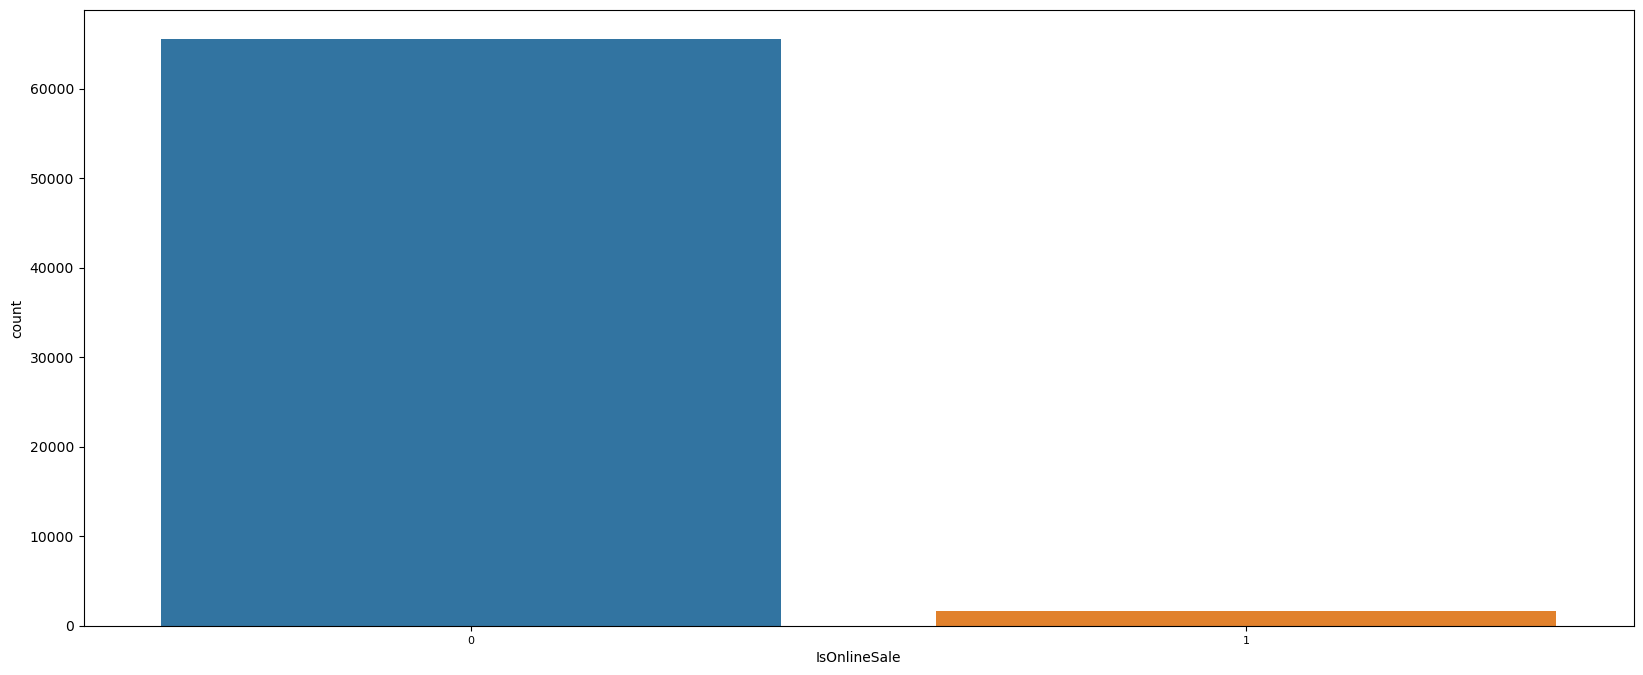

In [102]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
plt.rc('xtick',labelsize=8)
sns.countplot(x = "IsOnlineSale", data = car_kick)
plt.show()

In [103]:
cat_features.append('IsOnlineSale')

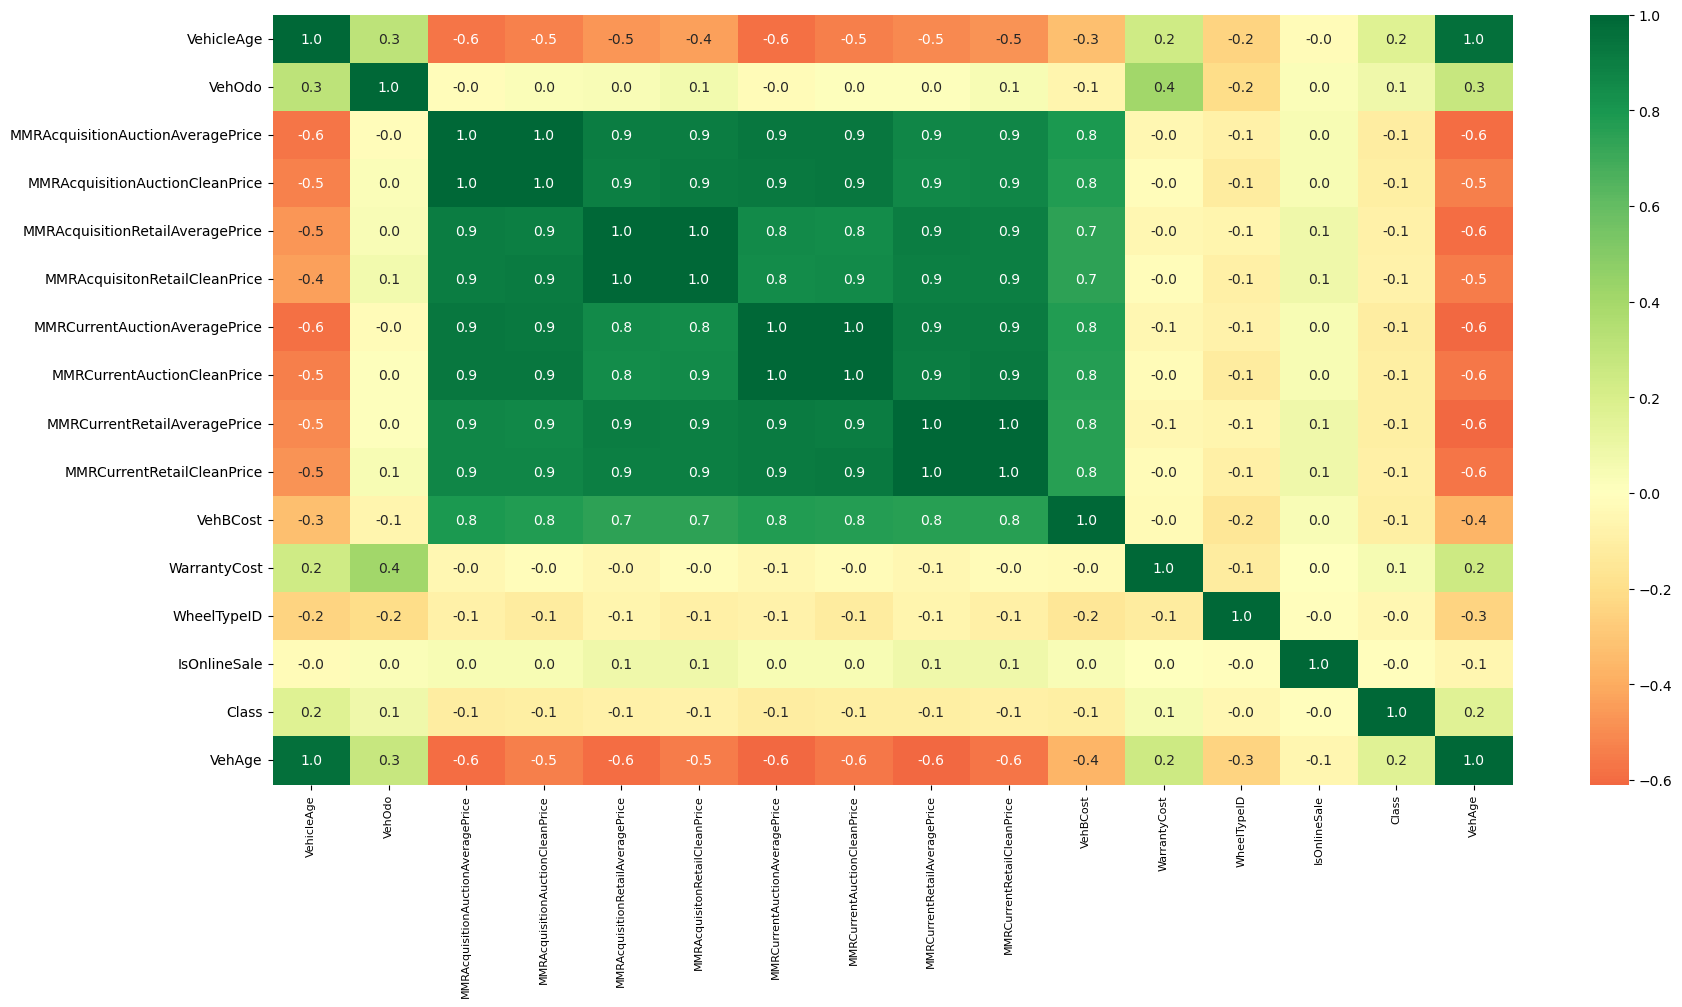

In [104]:
def plot_heat_map(dataframe):
    color = plt.get_cmap('RdYlGn')   # default color
    color.set_bad('lightblue')
    plt.subplots(figsize=(20, 10))
    sns.heatmap(dataframe.corr(numeric_only=True),  annot=True, fmt='.1f', center=0, cmap=color)
    return plt.show()
plot_heat_map(car_kick)

In [105]:
print('Numerical variables: ', num_features)

Numerical variables:  ['VehAge', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost']


In [106]:
print('Categorical variables: ', cat_features)

Categorical variables:  ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'IsOnlineSale']


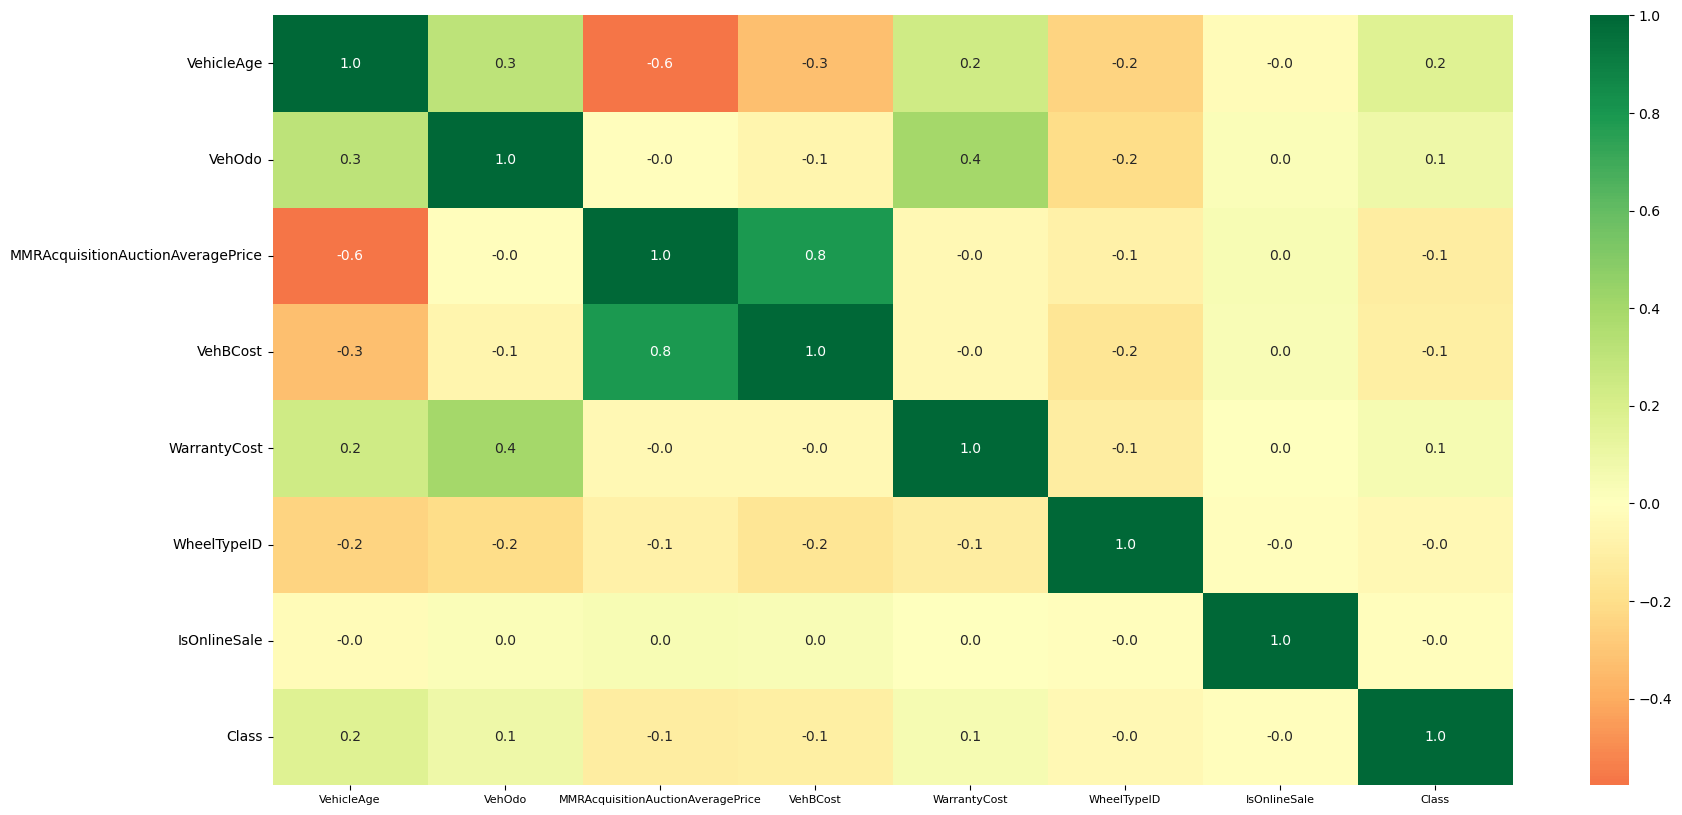

In [107]:
# Delete high correlated columns
corr_matrix = car_kick.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)] 
new_car_kick = car_kick.drop(to_drop, axis=1)
all_features = new_car_kick.columns.to_list()

plot_heat_map(new_car_kick)

In [108]:
num_features = list(set(all_features) - set(cat_features))

In [109]:
# # Interactions to Add
# for i, j in combinations(range(new_car_kick[new_car_kick.corr(numeric_only=True).columns].shape[1]), 2):
#     if (new_car_kick.corr(numeric_only=True) > .4).iloc[i, j] or (new_car_kick.corr(numeric_only=True) < -.4).iloc[i, j]:
#         print('added', new_car_kick.corr(numeric_only=True).columns[i], new_car_kick.corr(numeric_only=True).columns[j])
#         new_car_kick[f'{new_car_kick.columns[i]}_{new_car_kick.columns[j]}'] = new_car_kick[new_car_kick.corr(numeric_only=True).columns[j]] * new_car_kick[new_car_kick.corr(numeric_only=True).columns[j]]
#         num_features.append(f'{new_car_kick.columns[i]}_{new_car_kick.columns[j]}')

In [110]:
# new_car_kick['Cluster'] = KMeans(n_clusters = 3, n_init = 20).fit(new_car_kick[num_features].drop("Class", axis=1)).labels_
# num_features.append('Cluster')
# num_features.remove("Class")
# print('The final dimenssion of the dataset is:', new_car_kick.shape)

In [111]:
X  = new_car_kick.drop('Class', axis=1)
y = new_car_kick["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state, shuffle=True, stratify=y)
print("Count train data:",X_train.shape, y_train.shape)
print("Count test data:",X_test.shape, y_test.shape)

Count train data: (40326, 21) (40326,)
Count test data: (26885, 21) (26885,)


In [112]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X = X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns = new_columns, index = X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns

In [113]:
encoder = OneHotEncoder()
encoder_cols_train = encoder.fit_transform(X_train[cat_features].astype(str))
encoder_cols_test = encoder.transform(X_test[cat_features].astype(str))

In [117]:
num_features.remove("Class") #Later if we add interacto

In [118]:
# Add one-hot encoded columns to numerical features
X_train = pd.concat([X_train[num_features], encoder_cols_train], axis=1)
X_train_cols = X_train.columns
X_test = pd.concat([X_test[num_features], encoder_cols_test], axis=1)

In [258]:
print(X_train.shape)
print(X_test.shape) 

(40326, 168)
(26885, 168)


In [259]:
# Data modelling

In [260]:
# Recursive Feature Elimination with Cross-Validation
estimator = LogisticRegression()
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(n_splits=3), scoring='roc_auc', min_features_to_select = 10) #accuracy

rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
selected_features

Index(['VehicleAge', 'WarrantyCost', 'VehBCost', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice',
       'VehicleAge_MMRAcquisitionAuctionAveragePrice', 'VehOdo_WarrantyCost',
       'MMRAcquisitionAuctionAveragePrice_VehBCost', 'Cluster',
       'IsOnlineSale_0'],
      dtype='object')

In [261]:
important_features = selected_features.to_list()
X_train = X_train[important_features]
X_test = X_test[important_features]

X_train.shape, y_train.shape

((40326, 10), (40326,))

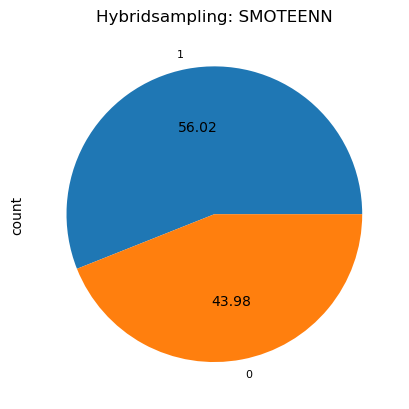

In [262]:
# Balance dataset
se =  SMOTEENN(random_state=0)
X_train, y_train = se.fit_resample(X_train, y_train)
ax = y_train.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("Hybridsampling: SMOTEENN")

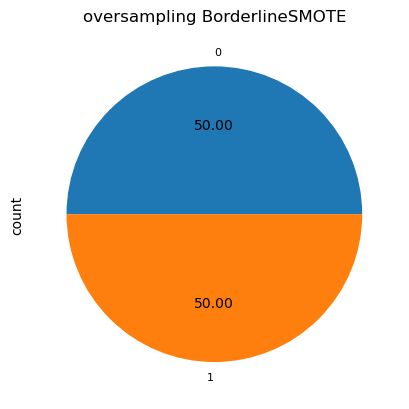

In [263]:
bs = BorderlineSMOTE(random_state=0)
X_train, y_train = bs.fit_resample(X_train, y_train)
ax = y_train.value_counts().plot.pie(autopct="%.2f")
_ = ax.set_title("oversampling BorderlineSMOTE")

In [264]:
# Models 

In [265]:
# Empty models 
models_empty = [
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=random_state),
        'params': {}
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=random_state),
        'params': {}
    
    },
    {
        'name': 'Neural Network',
        'model': MLPClassifier(random_state=random_state),
        'params': {}
    }
]

In [266]:
results_empty_models = []
# Define the cross-validation pipeline for each model
for model in models_empty:
    pipeline = Pipeline([
        ('classifier', model['model']) #('scaler', StandardScaler()),
    ])
    
    # Use GridSearchCV to perform hyperparameter tuning
    grid_search = RandomizedSearchCV(pipeline, model['params'], cv=3, n_jobs=-1, scoring='roc_auc') #  scoring='roc_auc' 'accuracy', 'precision','recall','roc_auc',f1
    grid_search.fit(X_train, y_train)
    results_empty_models.append({
            'Model': model['name'],
            'Best parameters': grid_search.best_params_,
            'Best score': grid_search.best_score_
            })
    
df_models_empty = pd.DataFrame(results_empty_models)

In [267]:
df_models_empty

,Model,Best parameters,Best score
0,Decision Tree,{},0.806204
1,Random Forest,{},0.974322
2,Neural Network,{},0.538554


In [268]:
# from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
# from hyperopt import Trials

In [269]:
# Define the models to be tested
models = [
    {
    'name': 'Decision Tree',
    'model': DecisionTreeClassifier(random_state=random_state),
    'params': {
        'classifier__max_depth': [None], #[2, 5, 7, None],
        'classifier__min_samples_split':[5], #[2, 5, 7],
        'classifier__min_samples_leaf': [5],# [1, 5, 7],
        }
    },
    {
    'name': 'Random Forest',
    'model': RandomForestClassifier(random_state=random_state),
    'params': {
        'classifier__n_estimators': [10, 100, 300, 500],
        'classifier__max_depth': [5, 50, 100], #[2, 5, 7, None],
        'classifier__min_samples_split': [2, 10, 20],
        #'classifier__min_samples_leaf': [1, 3, 5, 7]
        'classifier__max_features': [10, 20]
        }
    },
    {
    'name': 'Neural Network',
    'model': MLPClassifier(random_state=random_state),
    'params': {
        'classifier__hidden_layer_sizes': [(128,), (200,)],
        'classifier__solver': ['lbfgs'], #, 'sgd', 'adam'],
        'classifier__learning_rate_init': [0.001],
        'classifier__alpha': [0.0001, 0.1],
        'classifier__max_iter': [500, 700, 900]
        }
    }
]


In [270]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

In [271]:
results = []
# Define the cross-validation pipeline for each model
for model in models:
    pipeline = Pipeline([
        ('classifier', model['model']) #('scaler', StandardScaler()),
    ])
    #print(pipeline.get_params().keys())
    
    # Use GridSearchCV to perform hyperparameter tuning
    grid_search = GridSearchCV(pipeline, model['params'], cv=3, scoring='roc_auc') #  scoring='roc_auc' 'accuracy', 'precision','recall','roc_auc',f1
    grid_search.fit(X_train, y_train)
    results.append({
            'Model': model['name'],
            'Best parameters': grid_search.best_params_,
            'Best score': grid_search.best_score_
            })
    
df_result = pd.DataFrame(results)

In [272]:
#20.06
grid_search.cv_results_
df_result = df_result.sort_values(by=['Best score'],ascending=False)
df_result.head()

,Model,Best parameters,Best score
1,Random Forest,"{'classifier__max_depth': 50, 'classifier__max...",0.941589
0,Decision Tree,"{'classifier__max_depth': None, 'classifier__m...",0.834303
2,Neural Network,"{'classifier__alpha': 0.0001, 'classifier__hid...",0.515120


In [273]:
# #17.53
# grid_search.cv_results_
# df_result = df_result.sort_values(by=['Best score'],ascending=False)
# df_result.head()

In [274]:
#grid_search.cv_results_ 
# df_result = df_result.sort_values(by=['Best score'],ascending=False)
# df_result.head()

In [275]:
df_result.iloc[0,1]

{'classifier__max_depth': 50,
 'classifier__max_features': 10,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100}

In [276]:
import re
for index, row in df_result.iterrows():
    print(row["Best parameters"])
    params_str = "("
    for key, value in row["Best parameters"].items():
        param_name = key.split("__")[1]  # extract the parameter name from the dictionary key
        if isinstance(value, str):
            param_value = f"'{value}'"  # wrap string values in quotes
        else:
            param_value = str(value)
        params_str += f"{param_name}={param_value}, "

    params_str = params_str[:-2]  # remove the final comma and space
    params_str += ")"
    print(params_str)
    print(str(models[index]['model'])[:-2]+params_str)

{'classifier__max_depth': 50, 'classifier__max_features': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
(max_depth=50, max_features=10, min_samples_split=2, n_estimators=100)
RandomForestClassifier(random_state=4(max_depth=50, max_features=10, min_samples_split=2, n_estimators=100)
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}
(max_depth=None, min_samples_leaf=5, min_samples_split=5)
DecisionTreeClassifier(random_state=4(max_depth=None, min_samples_leaf=5, min_samples_split=5)
{'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (200,), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 500, 'classifier__solver': 'lbfgs'}
(alpha=0.0001, hidden_layer_sizes=(200,), learning_rate_init=0.001, max_iter=500, solver='lbfgs')
MLPClassifier(random_state=4(alpha=0.0001, hidden_layer_sizes=(200,), learning_rate_init=0.001, max_iter=500, solver='lbfgs')


In [277]:
print("The best model is " + df_result.iloc[0][0])
best_params = sorted(results, key=lambda k: k['Best score'], reverse=True)[0]["Best parameters"]
print("Parameters:", best_params)
for model in models:
    if str(model["name"]) == str(df_result.iloc[0][0]):
        #print(model["model"].get_params())
        #print(pipeline.get_params().keys())
        
        pipe_finall = Pipeline(steps = [
            ('scaler', StandardScaler()),
            ('classifier', model["model"])
            ])
        

The best model is Random Forest
Parameters: {'classifier__max_depth': 50, 'classifier__max_features': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [278]:
pipe_finall.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [279]:
y_pred = pipe_finall.predict(X_test)
y_pred_proba = pipe_finall.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]

In [280]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     24319
           1       0.17      0.26      0.21      2566

    accuracy                           0.81     26885
   macro avg       0.54      0.56      0.55     26885
weighted avg       0.85      0.81      0.83     26885



In [281]:
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("Recall = ",recall_score(y_test, y_pred))
print("Precision = ",precision_score(y_test, y_pred))
print("F1 = ",f1_score(y_test, y_pred))

Accuracy =  0.8074018969685698
Recall =  0.2642244738893219
Precision =  0.17086693548387097
F1 =  0.20752984389348025


Axes(0.125,0.11;0.62x0.77)


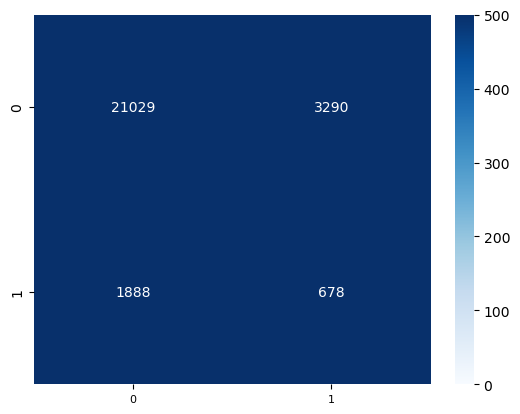

In [282]:
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=500,annot=True,cmap='Blues',fmt='g'));

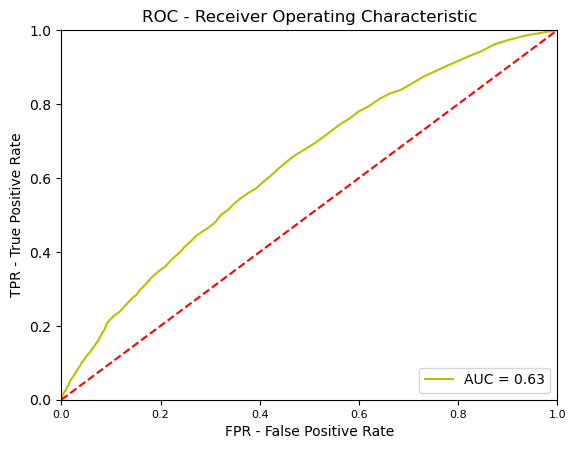

In [283]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.title('ROC - Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR - True Positive Rate')
plt.xlabel('FPR - False Positive Rate')
plt.show()

In [284]:
index_df = []
scores = {"Accuracy": [], "Recall": [], "Precision": [], "F1": []}
scoring = ["accuracy", 'recall','precision', 'f1']

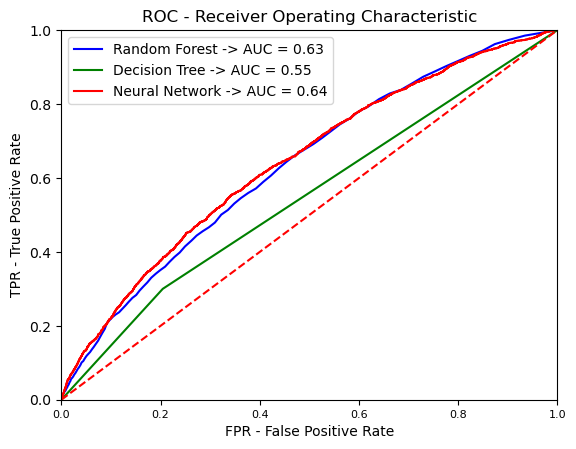

In [285]:
colors = ["green", "blue", "red"]
plt.figure(0).clf()
for index, row in df_result.iterrows():
    #eval(str(models[index]['model'])[:-2]+params_str))
    
    for model in models:
        if str(model["name"]) == str(row["Model"]):
            #print(model["model"].get_params())
            #print(pipeline.get_params().keys())

            pipe_finall = Pipeline(steps = [
                ('scaler', StandardScaler()),
                ('classifier', model["model"])
                ])
            pipe_finall.fit(X_train, y_train)
            y_pred = pipe_finall.predict(X_test)
            y_pred_proba = pipe_finall.predict_proba(X_test)
            y_pred_proba = y_pred_proba[:,1]
            
            index_df += [str(model["name"])]
            scores["Accuracy"].append(accuracy_score(y_test,y_pred))
            scores["Recall"].append(recall_score(y_test, y_pred))
            scores["Precision"].append(precision_score(y_test, y_pred))
            scores["F1"].append(f1_score(y_test, y_pred))
            df_scores = pd.DataFrame(scores, index=index_df)
            
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.title('ROC - Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'y', label = model["name"]+' -> AUC = %0.2f' % roc_auc, color=colors[index])
            
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR - True Positive Rate')
plt.xlabel('FPR - False Positive Rate')
plt.legend(loc=0)
plt.show()

In [286]:
df_scores[['Accuracy', 'Recall', 'Precision', 'F1']]

,Accuracy,Recall,Precision,F1
Random Forest,0.807402,0.264224,0.170867,0.207530
Decision Tree,0.748298,0.300078,0.134123,0.185386
Neural Network,0.649991,0.549493,0.145902,0.230581
